# How Much Did It Rain? II

Соревнование "How Much Did It Rain? II".
Цель состоит в том, чтобы предсказать почасовое количество осадков, используя данные радара.

Ссылка на соревнование: https://www.kaggle.com/competitions/how-much-did-it-rain-ii/overview

In [1]:
import logging
import os
import warnings
from typing import Any, Dict, List, Optional

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import xgboost as xgb
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

# Настройка логгирования
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

c:\Users\kazan\itmo_vika\how-much-did-it-rain-ii\.venv1\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'nlp' extra dependency package 'fasttext-numpy2' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.


c:\Users\kazan\itmo_vika\how-much-did-it-rain-ii\.venv1\lib\site-packages\lightautoml\text\tokenizer.py:21: UserWarning: 'nltk' - package isn't installed
  warnings.warn("'nltk' - package isn't installed")
c:\Users\kazan\itmo_vika\how-much-did-it-rain-ii\.venv1\lib\site-packages\lightautoml\transformers\text.py:23: UserWarning: 'fasttext' - package isn't installed
  warnings.warn("'fasttext' - package isn't installed")


### Загрузка данных

In [2]:
train_df = pd.read_csv('data/train.csv')
logger.info(f"Train успешно загружен. Размер: {train_df.shape}")

test_df = pd.read_csv('data/test.csv')
logger.info(f"Test успешно загружен. Размер: {test_df.shape}")

2025-12-29 17:31:52,089 - INFO - Train успешно загружен. Размер: (13765201, 24)
2025-12-29 17:31:55,647 - INFO - Test успешно загружен. Размер: (8022756, 23)


### Структура данных
Таргет Expected - это показание датчика в конце часа, оно одинаково для всех строк с одним и тем же Id.\
Для анализа таргета нужно будет агрегировать данные, чтобы получить одну строку на каждый Id.

In [3]:
# Получение уникальных целевых значений для каждого Id
unique_targets = train_df.groupby('Id')['Expected'].first()
print(f"Количество уникальных наблюдений датчиков (Ids): {len(unique_targets)}")
unique_targets.head()

Количество уникальных наблюдений датчиков (Ids): 1180945


Id
1      0.254000
2      1.016001
3     26.162014
4      4.064002
5    774.700440
Name: Expected, dtype: float64

## 1. Анализ целевой переменной

### 1.1 Численный анализ
Целевая переменная - ожидаемое количества осадков `Expected`.

#### 1.1.1 Распределение целевой переменной

In [4]:
# Основные статистики
print(f"Статистики целевой переменной:\n{unique_targets.describe()}")

print(f"\nSkewness: {unique_targets.skew():.2f}")
print(f"Kurtosis: {unique_targets.kurtosis():.2f}\n")

print(f"Пропущенные значения в целевой переменной: {unique_targets.isnull().sum()}")

Статистики целевой переменной:
count    1.180945e+06
mean     1.322453e+02
std      6.030804e+02
min      1.000000e-02
25%      2.540001e-01
50%      1.016001e+00
75%      3.810002e+00
max      3.301773e+04
Name: Expected, dtype: float64

Skewness: 10.06
Kurtosis: 304.07

Пропущенные значения в целевой переменной: 0


- Skewness = 10.06 указывает на очень сильную правостороннюю асимметрию. Распределение имеет длинный хвост в сторону больших значений. Это типично для данных об осадках, где большинство наблюдений - это отсутствие или малое количество дождя, но случаются редкие сильные ливни.
- Kurtosis = 304.07 (чрезвычайно высокое значение) указывает на то, что распределение имеет очень острый пик и тяжелые хвосты по сравнению с нормальным распределением. Это подтверждает наличие значительных выбросов.

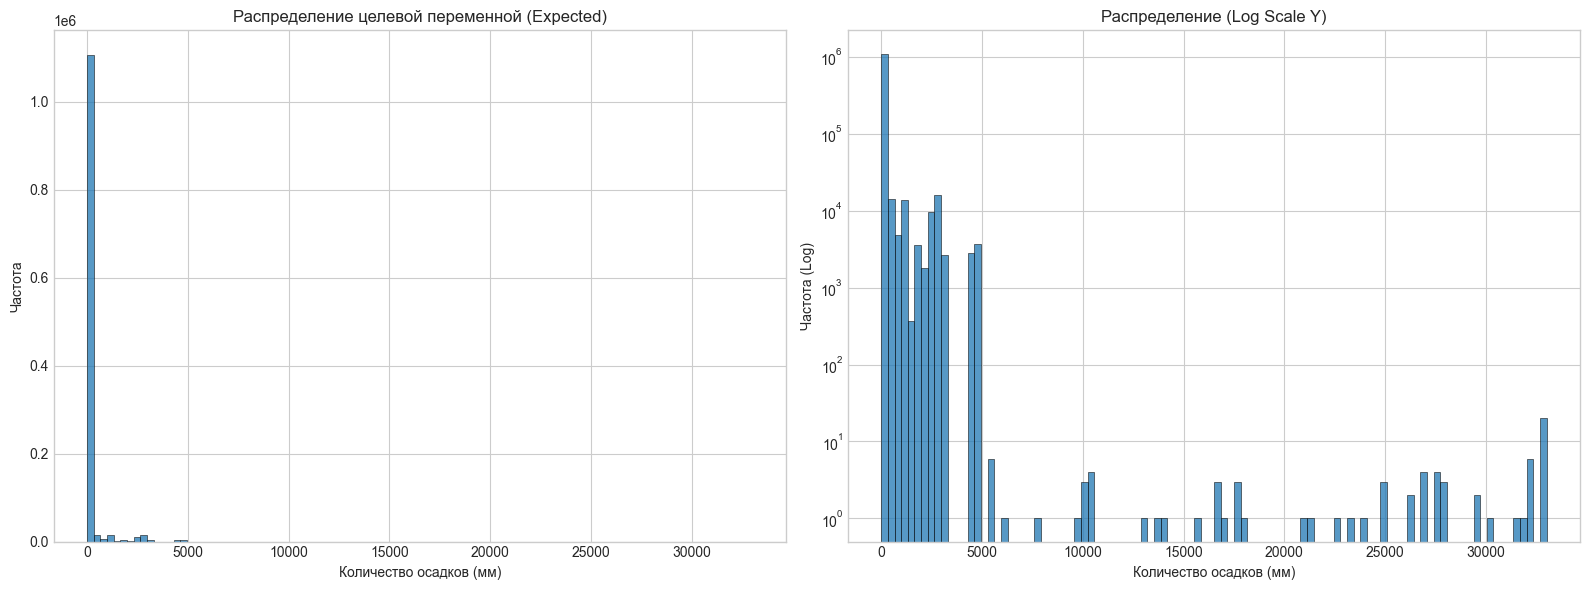

In [5]:
# Визуализация распределения целевой переменной
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Обычная шкала
sns.histplot(unique_targets, bins=100, kde=False, ax=axes[0])
axes[0].set_title('Распределение целевой переменной (Expected)')
axes[0].set_xlabel('Количество осадков (мм)')
axes[0].set_ylabel('Частота')

# Логарифмическая шкала по Y
sns.histplot(unique_targets, bins=100, kde=False, ax=axes[1])
axes[1].set_title('Распределение (Log Scale Y)')
axes[1].set_xlabel('Количество осадков (мм)')
axes[1].set_ylabel('Частота (Log)')
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()

#### 1.1.2 Обнаружение выбросов
Как выяснили, имеем дело с тяжелым хвостом, посмотрим на экстремальные значения.

In [6]:
# Квантили
quantiles = unique_targets.quantile([0.9, 0.95, 0.99, 0.999])
print(f"Квантили:\n{quantiles}")

# Определение экстремальных выбросов (> 99.9-го перцентиля)
threshold = quantiles[0.999]
outliers = unique_targets[unique_targets > threshold]
print(f"\nКоличество значений > {threshold:.2f}: {len(outliers)} из {len(unique_targets)} ({len(outliers)/len(unique_targets)*100:.2f}%)")
print(f"\nМаксимальное значение: {unique_targets.max()}")

# Количество значений меньше 1 мм
less_than_1 = unique_targets[unique_targets <= 1]
print(f"\nКоличество значений <= 1: {len(less_than_1)} из {len(unique_targets)} ({len(less_than_1)/len(unique_targets)*100:.2f}%)")

# Количество значений меньше 10 мм
less_than_10 = unique_targets[unique_targets <= 10]
print(f"Количество значений <= 10: {len(less_than_10)} из {len(unique_targets)} ({len(less_than_10)/len(unique_targets)*100:.2f}%)")

Квантили:
0.900      41.40002
0.950     676.99940
0.990    2945.13160
0.999    4720.59230
Name: Expected, dtype: float64

Количество значений > 4720.59: 80 из 1180945 (0.01%)

Максимальное значение: 33017.73

Количество значений <= 1: 553402 из 1180945 (46.86%)
Количество значений <= 10: 996449 из 1180945 (84.38%)


Значительная часть данных (46.86%) — это значения <=1 мм. Это означает, что в большинстве случаев дождя почти нет. \
Значения таргета <= 10 мм составляют 84.38%. \
Максимальное значение таргета при этом = 33017.73.

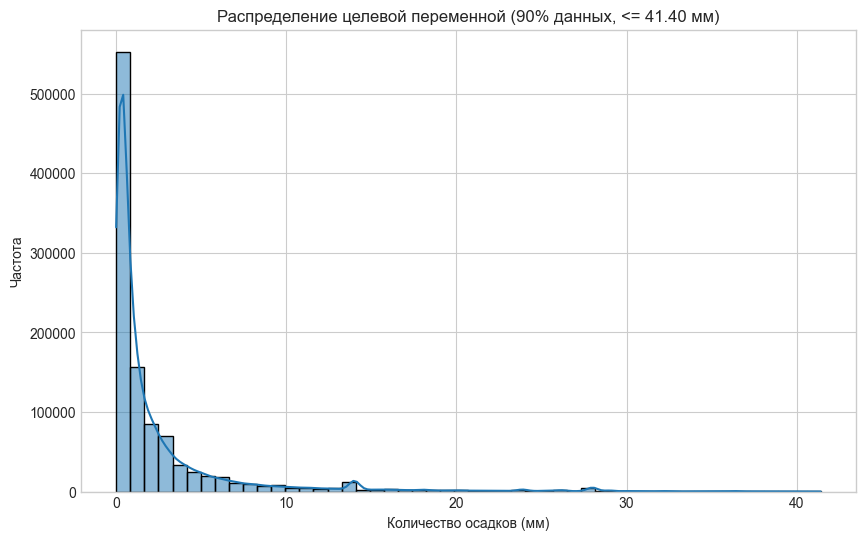

In [7]:
# Визуализация распределения для 90% данных (убираем топ 10% выбросов)
limit_90 = unique_targets.quantile(0.9)
plt.figure(figsize=(10, 6))
sns.histplot(unique_targets[unique_targets <= limit_90], bins=50, kde=True)
plt.title(f'Распределение целевой переменной (90% данных, <= {limit_90:.2f} мм)')
plt.xlabel('Количество осадков (мм)')
plt.ylabel('Частота')
plt.show()

### 1.2 Статистическая визуализация (Изолированный анализ)
Визуализация распределения с использованием гистограмм и boxplots.\
Поскольку данные сильно скошены, также посмотрим на логарифмически преобразованную целевую переменную.

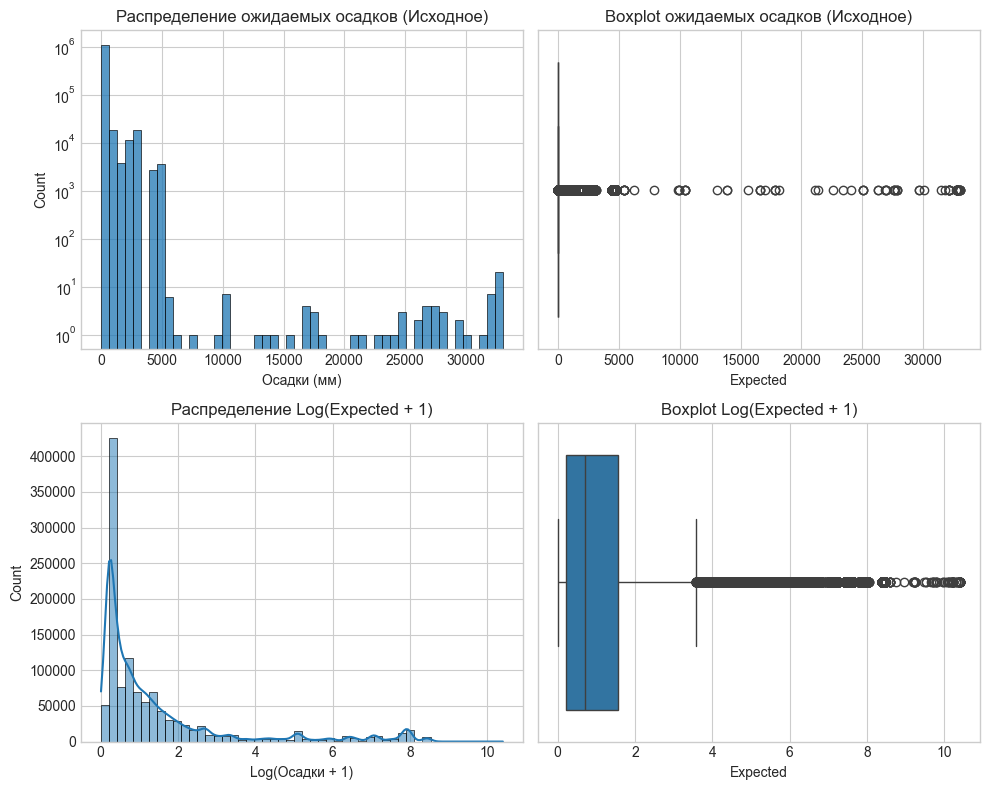

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Гистограмма для данных в исходном масштабе + логарифмическая шкала для оси Y, чтобы увидеть хвост
sns.histplot(unique_targets, bins=50, kde=False, ax=axes[0, 0])
axes[0, 0].set_title('Распределение ожидаемых осадков (Исходное)')
axes[0, 0].set_xlabel('Осадки (мм)')
axes[0, 0].set_yscale('log')

# Boxplot для данных в исходном масштабе
sns.boxplot(x=unique_targets, ax=axes[0, 1])
axes[0, 1].set_title('Boxplot ожидаемых осадков (Исходное)')

# Гистограмма логарифмически преобразованных данных (log1p для обработки нулей)
log_target = np.log1p(unique_targets)
sns.histplot(log_target, bins=50, kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Распределение Log(Expected + 1)')
axes[1, 0].set_xlabel('Log(Осадки + 1)')

# Boxplot логарифмически преобразованных данных
sns.boxplot(x=log_target, ax=axes[1, 1])
axes[1, 1].set_title('Boxplot Log(Expected + 1)')

plt.tight_layout()
plt.show()

Графики подтверждают выводы:
- Большинство значений сосредоточено около нуля.
- Хвост распределения очень длинный, т.е. есть редкие, но очень сильные дожди

#### Анализ во временном контексте

В соревновании данные перемешаны, и точное время и место измерений неизвестно.
Соответственно, мы не можем построить график осадков по дням, не можем проследить периодичность или сезонность, а также последовательность.

Есть колонка minutes_past (минуты от начала часа), но результат Expected (сколько выпало дождя) - это одно число для всего часа, поэтому анализ последовательности этой колонки тоже ничего не даст

Итого, можно попробовать проверить:
1.  Зависит ли таргет от Id (вдруг данные все-таки отсортированы?).
2.  Зависит ли таргет от количества записей радара в течение часа.

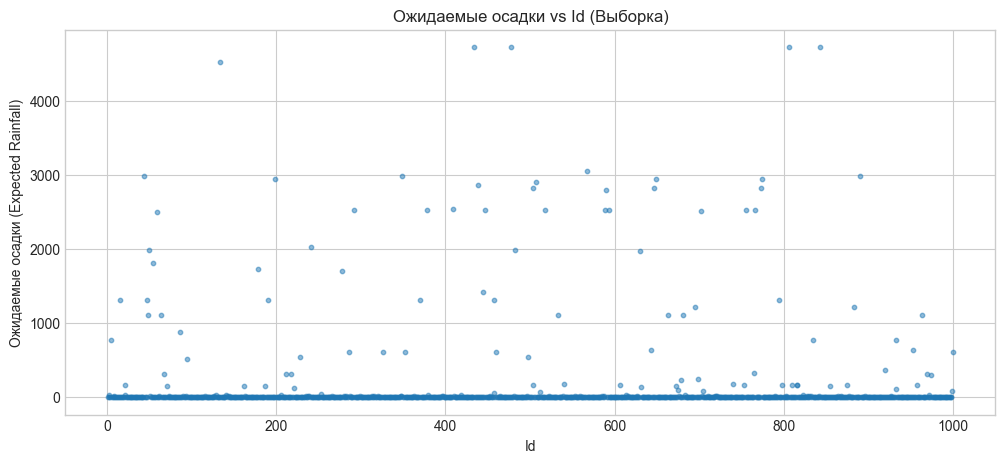

Корреляция между Id и Expected: -0.0019


In [9]:
# Проверка корреляции Id с целевой переменной (проверка на утечку данных)
# Построение графика выборки Ids против Expected
sample_targets = unique_targets.head(1000).sort_index()

plt.figure(figsize=(12, 5))
plt.scatter(sample_targets.index, sample_targets.values, alpha=0.5, s=10)
plt.title('Ожидаемые осадки vs Id (Выборка)')
plt.xlabel('Id')
plt.ylabel('Ожидаемые осадки (Expected Rainfall)')
plt.show()

# Корреляция между Id и целевой переменной
corr_id = unique_targets.reset_index().corr()['Expected']['Id']
print(f"Корреляция между Id и Expected: {corr_id:.4f}")

Корреляции с Id нет. Это значит, что данные действительно перемешаны и нет утечки информации через порядок строк.

Мы не можем использовать историю (прошлые часы) для предсказания будущего, так как порядок нарушен.

Общий вывод по таргету (Expected):
- Дождь идет редко. Почти половина значений <= 1 мм, почти 90% <= 10 мм
- Есть очень сильные ливни (или ошибки датчиков). Модели могут ошибаться на них

Практивческие выводы:
- Использовать метрику MAE (она устойчива к таким экстремальным выбросам). Она и указана в overview к соревке
- Экстремально большие значения редкие и вполне могут быть ошибками измерения, и если учить модель на них без ограничений, она начинает хуже предсказывать типичные случаи, которых больше всего (>90%). Поэтому для обучения я попробую взять 90% более типичных данных. Возможно, из-за этого я не смогу предсказывать штормы, но если в целом посмотреть на классификацию дождей - 40 мм/час - это уже ливень, так что не брать для обучения совсем экстремальные штормы, думаю, вполне оправданно для этой задачи.

## 2. Анализ признаков

### 2.0 Структура данных и описание признаков

В этом соревновании данные имеют специфическую структуру. Для каждого целевого значения (один час наблюдений на одном датчике, идентифицируемый по Id) у нас есть несколько строк данных.
- Каждая строка - это данные с радара в определенный момент времени внутри этого часа (minutes_past).
- Количество строк для разных Id может отличаться.
- Target (Expected) для всех строк с одинаковым Id - одинаковый

Фичи:\
Все фичи - числовые измерения с радаров. Основные фичи:
- Ref: отражаемость радара
- RhoHV: коэффициент корреляции
- Zdr: дифференциальная отражаемость
- Kdp: удельная дифференциальная фаза 
- radardist_km: расстояние от радара до датчика.

Для каждого из этих показателей (кроме расстояния) есть также агрегированные статистики по окрестности 5x5 км: _5x5_10th, _5x5_50th, _5x5_90th.

### 2.1 Анализ исходных данных (до агрегации)

#### 2.1.1 Типизация и распределения признаков (до агрегации)

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13765201 entries, 0 to 13765200
Data columns (total 24 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Id                     int64  
 1   minutes_past           int64  
 2   radardist_km           float64
 3   Ref                    float64
 4   Ref_5x5_10th           float64
 5   Ref_5x5_50th           float64
 6   Ref_5x5_90th           float64
 7   RefComposite           float64
 8   RefComposite_5x5_10th  float64
 9   RefComposite_5x5_50th  float64
 10  RefComposite_5x5_90th  float64
 11  RhoHV                  float64
 12  RhoHV_5x5_10th         float64
 13  RhoHV_5x5_50th         float64
 14  RhoHV_5x5_90th         float64
 15  Zdr                    float64
 16  Zdr_5x5_10th           float64
 17  Zdr_5x5_50th           float64
 18  Zdr_5x5_90th           float64
 19  Kdp                    float64
 20  Kdp_5x5_10th           float64
 21  Kdp_5x5_50th           float64
 22  Kdp_5x5_90th    

Все признаки числовые, нет категориальных и временных признаков. 

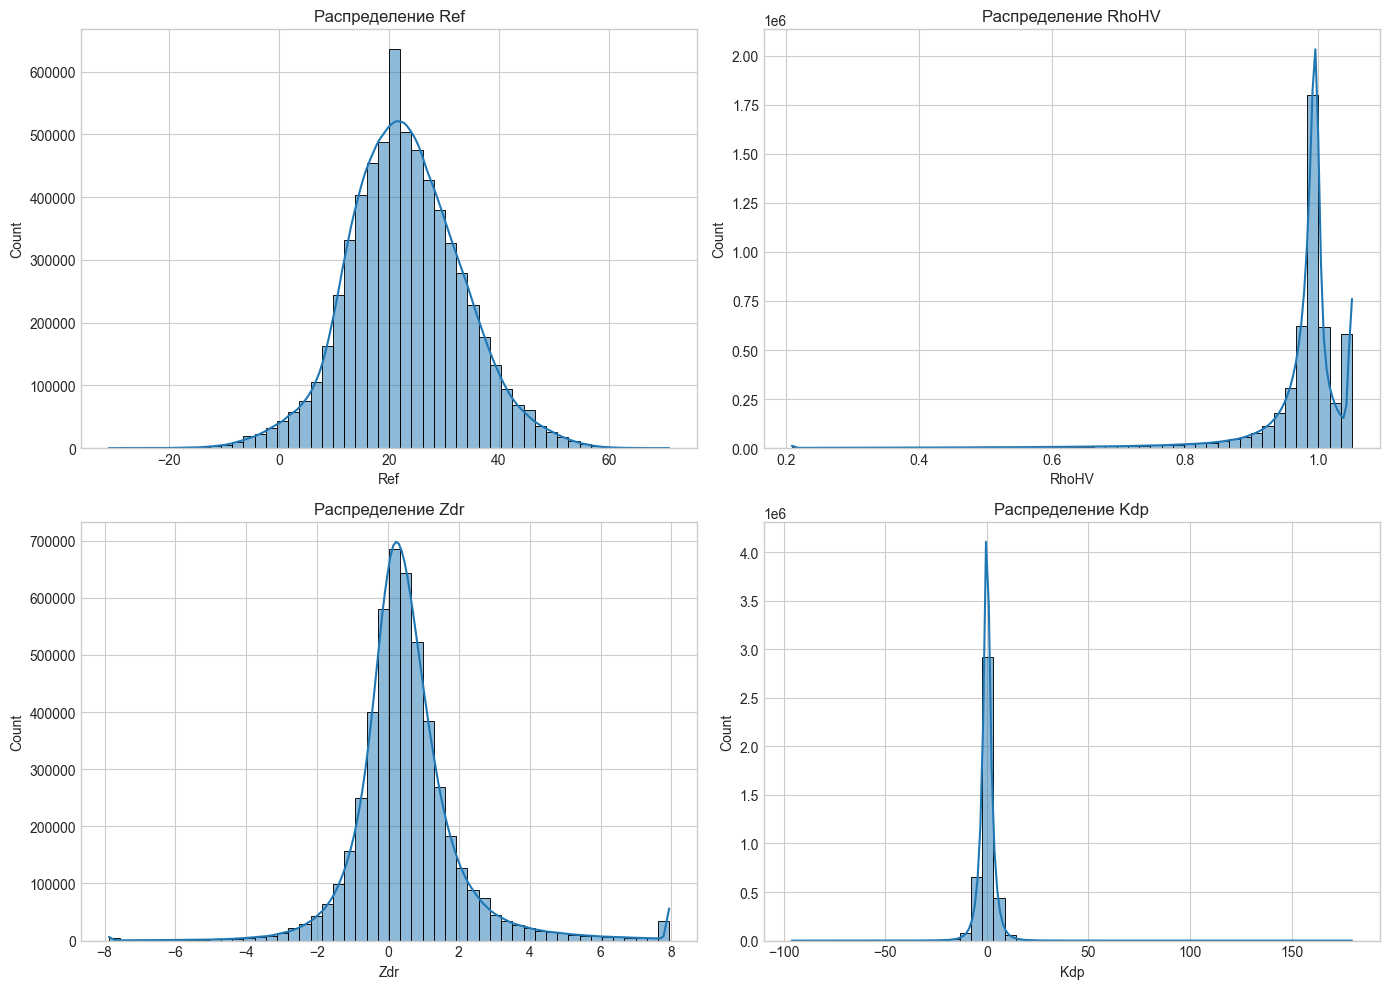

Описательные статистики:
                Ref         RhoHV           Zdr           Kdp
count  6.349375e+06  4.934916e+06  4.934916e+06  4.182635e+06
mean   2.292666e+01  9.728903e-01  5.367092e-01  3.545172e-02
std    1.035516e+01  9.074317e-02  1.510399e+00  3.869725e+00
min   -3.100000e+01  2.083333e-01 -7.875000e+00 -9.604000e+01
25%    1.600000e+01  9.716667e-01 -1.875000e-01 -1.410004e+00
50%    2.250000e+01  9.916667e-01  3.750000e-01  0.000000e+00
75%    2.950000e+01  1.001667e+00  1.062500e+00  1.750000e+00
max    7.100000e+01  1.051667e+00  7.937500e+00  1.797500e+02


In [11]:
# Выберем основные признаки для анализа
features_to_plot = ['Ref', 'RhoHV', 'Zdr', 'Kdp']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, col in enumerate(features_to_plot):
    sns.histplot(train_df[features_to_plot][col], bins=50, kde=True, ax=axes[i])
    axes[i].set_title(f'Распределение {col}')
    axes[i].set_xlabel(col)

plt.tight_layout()
plt.show()

# Описательные статистики для этих признаков
print(f"Описательные статистики:\n{train_df[features_to_plot].describe()}")

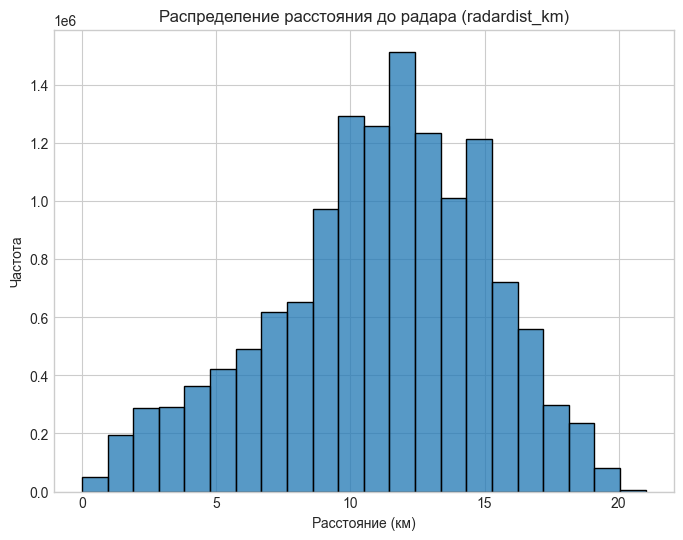

Статистика расстояния до радара:
count    1.376520e+07
mean     1.106794e+01
std      4.206618e+00
min      0.000000e+00
25%      9.000000e+00
50%      1.100000e+01
75%      1.400000e+01
max      2.100000e+01
Name: radardist_km, dtype: float64


In [12]:
# Распределение расстояния до радара
plt.figure(figsize=(8, 6))
sns.histplot(train_df['radardist_km'], bins=train_df['radardist_km'].nunique())
plt.title('Распределение расстояния до радара (radardist_km)')
plt.xlabel('Расстояние (км)')
plt.ylabel('Частота')
plt.show()

print(f"Статистика расстояния до радара:\n{train_df['radardist_km'].describe()}")

Все признаки числовые, нет категориальных признаков. В основном все признаки float, только расстояние измеряется в целых значениях километров (от 0 до 21 км).

Выводы по распределениям признаков:
1.  Ref (Отражаемость): распределение нормальное
2.  RhoHV (Корреляция): пик распределения находится очень близко к 1.0, что ожидаемо для дождя. Значения ниже 0.8-0.9 могут быть шумом.
3.  Zdr (Диф. отражаемость): распределение центрировано около 0, с небольшим смещением в положительную сторону (капли дождя сплюснуты).
4.  Kdp: распределение очень узкое с центром около 0.
5.  Расстояние: датчики расположены на разном удалении от радаров, расстояние в целом важный фактор, так как качество сигнала падает с увеличением расстояния

Фичи, показывающие физические состояния, различны в течение часа. Интересно посмотреть на фичи radardist_km и minutes_past. В первом случае интересно, все ли измерения в течение часа были замерены с одного и того же радара. Во втором случае интересно, сколько различных измерений внутри часа могут быть записаны.

Количество уникальных расстояний до радара внутри одного часа (Id):

radardist_km
1    1180945
Name: count, dtype: int64

Вывод: Для каждого Id все измерения сделаны с одного и того же расстояния (одного радара).

Статистика по количеству измерений на один Id:

count    1.180945e+06
mean     1.165609e+01
std      3.254159e+00
min      1.000000e+00
25%      1.000000e+01
50%      1.200000e+01
75%      1.400000e+01
max      1.900000e+01
dtype: float64


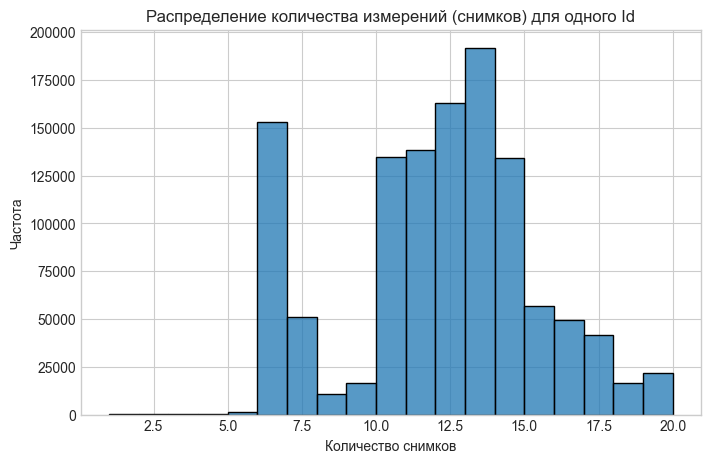

In [13]:
# 1. Проверка постоянства расстояния до радара для одного Id
radar_counts = train_df.groupby('Id')['radardist_km'].nunique()
print("Количество уникальных расстояний до радара внутри одного часа (Id):")
print(f"\n{radar_counts.value_counts()}")

if radar_counts.max() == 1:
    print("\nВывод: Для каждого Id все измерения сделаны с одного и того же расстояния (одного радара).")
else:
    print("\nВывод: Есть случаи, когда для одного Id измерения с разных расстояний.")

# 2. Анализ количества измерений (снимков) внутри часа
measurements_per_id = train_df.groupby('Id').size()

print("\nСтатистика по количеству измерений на один Id:")
print(f"\n{measurements_per_id.describe()}")

plt.figure(figsize=(8, 5))
sns.histplot(measurements_per_id, bins=range(1, measurements_per_id.max() + 2), kde=False)
plt.title('Распределение количества измерений (снимков) для одного Id')
plt.xlabel('Количество снимков')
plt.ylabel('Частота')
plt.show()

Итого, да, все измерения в течение часа выполнены на одном и том же удалении, а количество измерений в течение часа действительно разное - от 1 до 19

#### 2.1.2 Аномалии в исходных данных

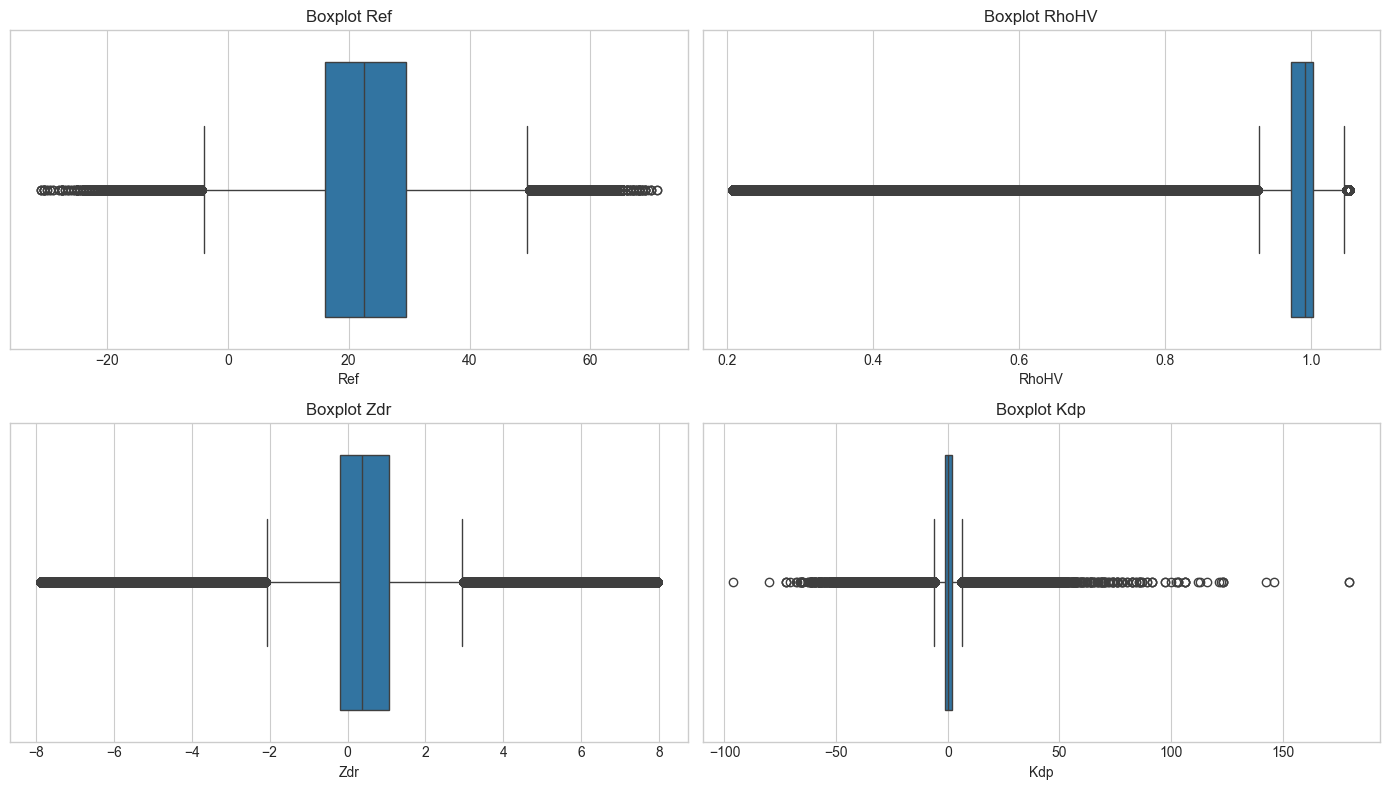

Количество записей с RhoHV > 1.0: 1428166


In [14]:
# Анализ выбросов с помощью Boxplot для основных признаков
features_to_check = ['Ref', 'RhoHV', 'Zdr', 'Kdp']

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

for i, col in enumerate(features_to_check):
    sns.boxplot(x=train_df[col], ax=axes[i])
    axes[i].set_title(f'Boxplot {col}')

plt.tight_layout()
plt.show()

# Проверка на физическую корректность RhoHV
invalid_rhohv = train_df[train_df['RhoHV'] > 1.0]
print(f"Количество записей с RhoHV > 1.0: {len(invalid_rhohv)}")

Практические выводы:
- RhoHV клипнуть значения > 1.0, так как это физически невозможно
- В остальных признаках не удалять выбросы, так как это может быть полезный сигнал. К тому же, данные все равно будут сагрегированы

#### 2.1.3 Анализ зависимости между признаками

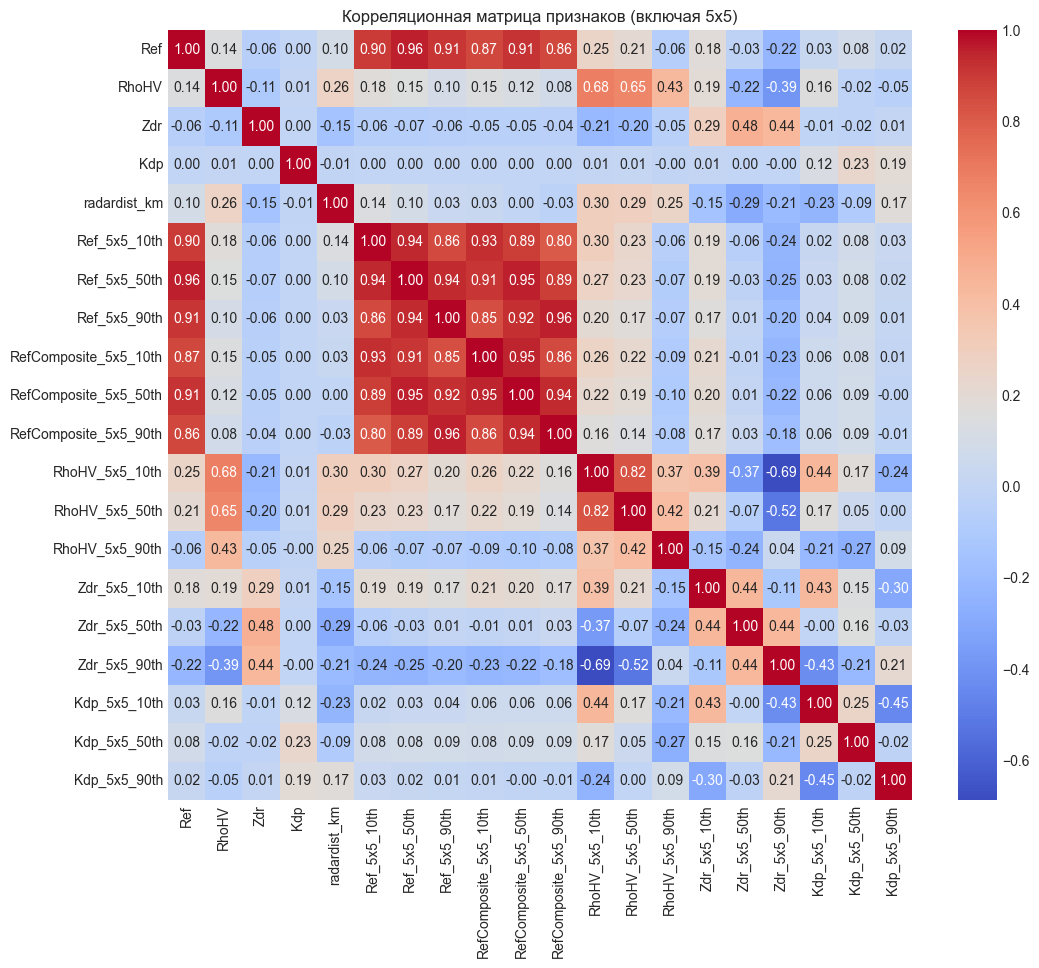

In [15]:
# Корреляционная матрица признаков
# Рассмотрю не только основные признаки, но и агреированные статистики по окрестности 5x5
features_to_corr = ['Ref', 'RhoHV', 'Zdr', 'Kdp', 'radardist_km']
features_5x5 = [c for c in train_df.columns if '5x5' in c]
features_to_corr.extend(features_5x5)

corr_matrix_features = train_df[features_to_corr].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_features, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляционная матрица признаков (включая 5x5)')
plt.show()

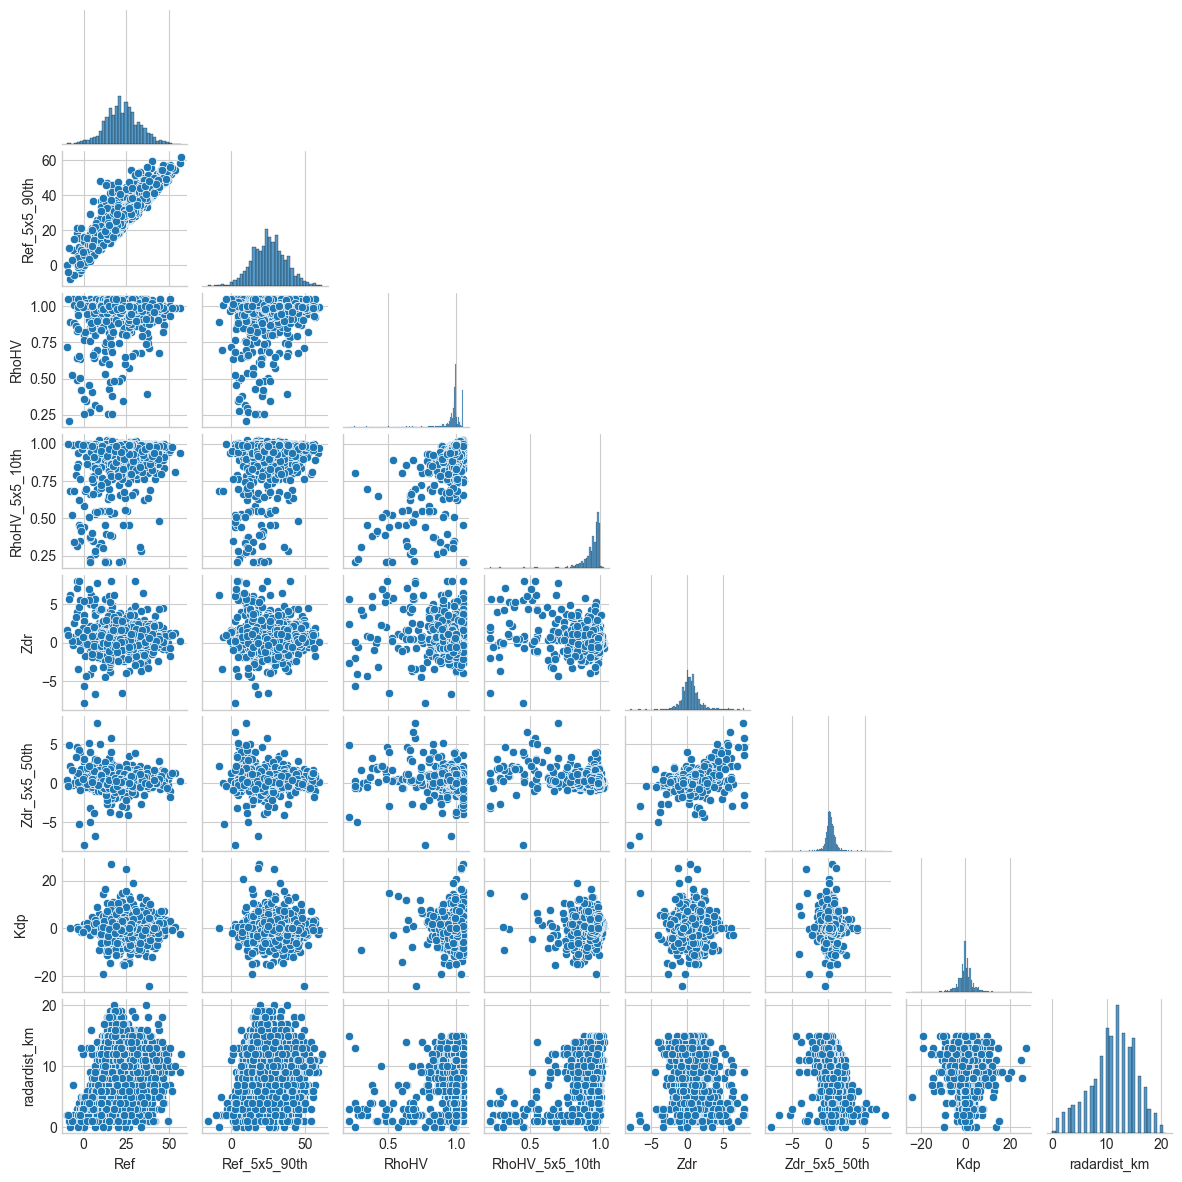

In [16]:
# Попарные диаграммы рассеяния (Pairplot)
# Здесь возьму только основные признаки и пару 5x5 для сравнения
cols_for_pairplot = ['Ref', 'Ref_5x5_90th', 'RhoHV', 'RhoHV_5x5_10th', 'Zdr', 'Zdr_5x5_50th',  'Kdp', 'radardist_km']

data_for_plot = train_df[cols_for_pairplot].sample(n=5000, random_state=42)

sns.pairplot(data_for_plot, diag_kind="hist", corner=True, height=1.5)
plt.show()

Выводы по зависимостям (с учетом 5x5 признаков):
- Мультиколлинеарность 5x5: корреляция между основными признаками и их агрегированными версиями (Ref_5x5_50th, Zdr_5x5_90th) крайне высока (>0.5, иногда близка к 1.0). Это подтверждает, что они описывают одно и то же явление, но с разной степенью сглаживания.
- Корреляция между Ref и другими физическими параметрами (Zdr, Kdp) умеренная -> Zdr и Kdp несут уникальную информацию, не дублируя Ref.
- Связь Ref и Ref_5x5_90th на pairplot выглядит как узкое облако вдоль диагонали - почти линейная зависимость.
- Связи между разными типами измерений (например, Ref vs Zdr) имеют форму веера или бесформенного облака -> линейные модели скорее всего будут хуже, чем например бустинг

#### 2.1.4 Посмотрим на пропуски в исходном формате (построчно).

2025-12-29 17:33:22,136 - INFO - Топ признаков с пропущенными значениями:
2025-12-29 17:33:22,136 - INFO - 
                Missing Values  Percentage
Kdp_5x5_10th          10336419   75.090941
RhoHV_5x5_10th         9632047   69.973893
Zdr_5x5_10th           9632047   69.973893
Kdp                    9582566   69.614428
Kdp_5x5_50th           9577920   69.580677
RhoHV                  8830285   64.149336
Zdr                    8830285   64.149336
RhoHV_5x5_50th         8828633   64.137334
Zdr_5x5_50th           8828633   64.137334
Kdp_5x5_90th           8712425   63.293119


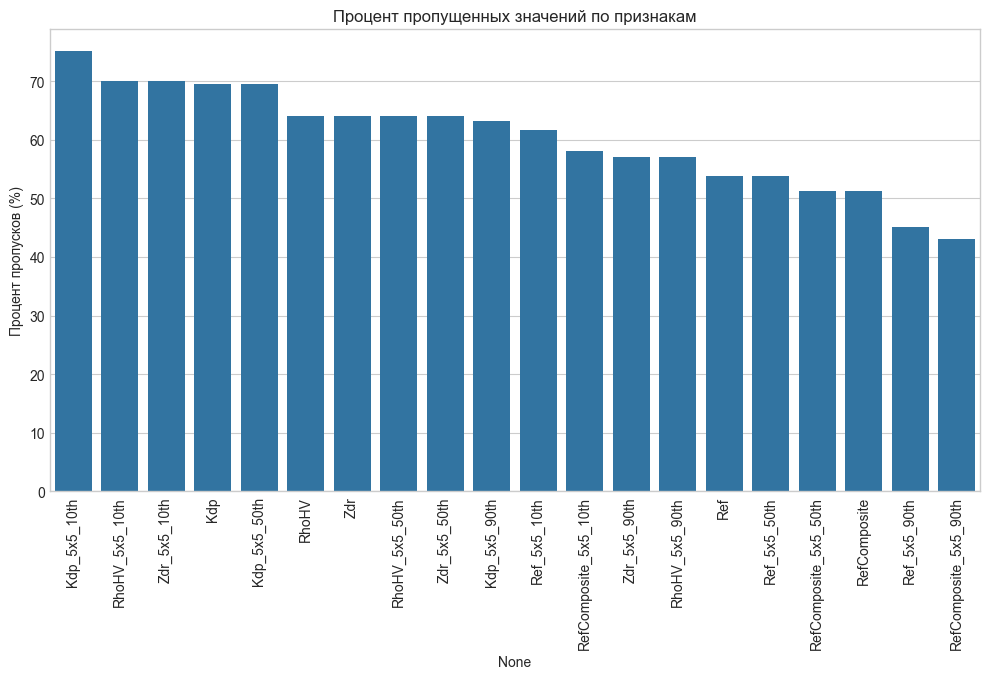

In [17]:
# Проверка пропущенных значений
missing_values = train_df.isnull().sum()
missing_percent = (missing_values / len(train_df)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percent})
missing_df = missing_df[missing_df['Missing Values'] > 0].sort_values(by='Percentage', ascending=False)

logger.info("Топ признаков с пропущенными значениями:")
logger.info(f"\n{missing_df.head(10)}")

# Визуализация пропусков
plt.figure(figsize=(12, 6))
sns.barplot(x=missing_df.index, y=missing_df['Percentage'])
plt.xticks(rotation=90)
plt.title('Процент пропущенных значений по признакам')
plt.ylabel('Процент пропусков (%)')
plt.show()

Выводы по пропущенным значениям:

- В данных наблюдается значительное количество пропусков. В контексте радарных измерений NaN часто несет физический смысл, это может означать отсутствие осадков в данной точке. Также помним, что для разных Id было разное количество измерений внутри часа

Стратегия обработки:
- Для линейных моделей пропуски необходимо заполнять.
- Градиентный бустинг (и LAMA) умеет работать с пропусками.


Также не забываем, что данные мы будем агрегировать (свертывать по Id)

#### 2.1.5 Определение важности признаков, корреляции с таргетом

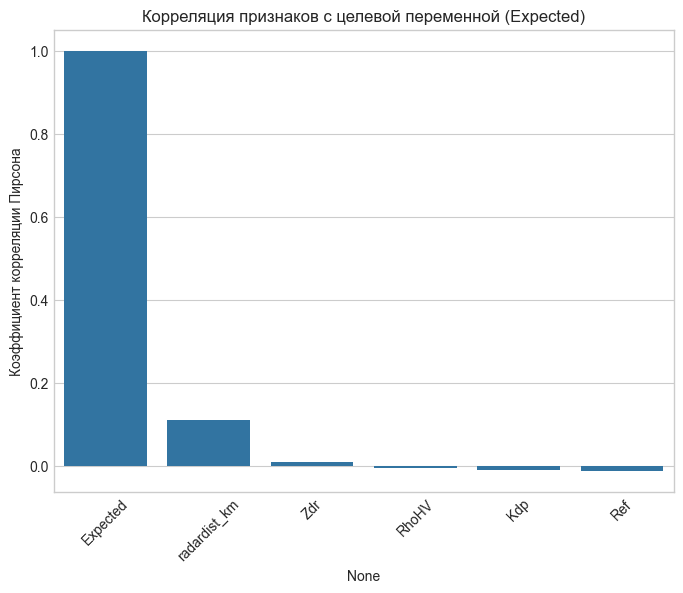

Корреляция с Expected:

Expected        1.000000
radardist_km    0.112154
Zdr             0.008972
RhoHV          -0.004703
Kdp            -0.010206
Ref            -0.011427
Name: Expected, dtype: float64


In [18]:
# Корреляция признаков с целевой переменной
# Добавим Expected к выборке
sample_corr_target = train_df[['Ref', 'RhoHV', 'Zdr', 'Kdp', 'radardist_km', 'Expected']].sample(n=100000, random_state=42)
corr_with_target = sample_corr_target.corr()['Expected'].sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x=corr_with_target.index, y=corr_with_target.values)
plt.title('Корреляция признаков с целевой переменной (Expected)')
plt.ylabel('Коэффициент корреляции Пирсона')
plt.xticks(rotation=45)
plt.show()

print("Корреляция с Expected:")
print(f"\n{corr_with_target}")

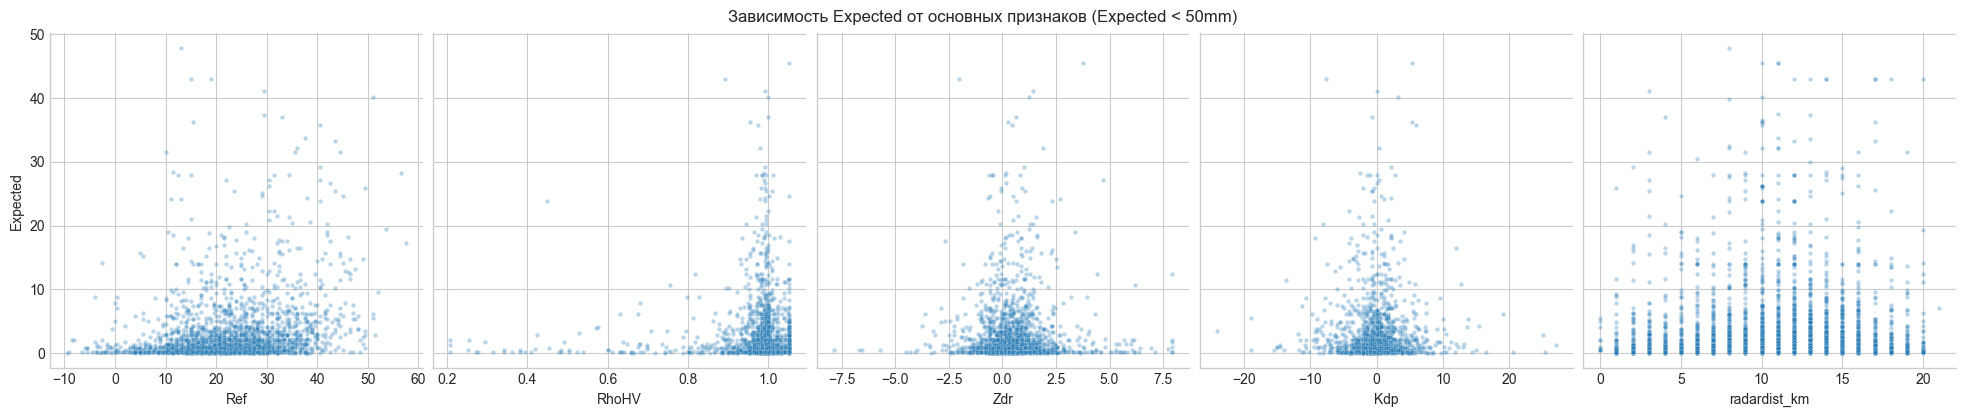

In [19]:
# Pairplot: признаки vs target

# уберу экстремальные ливни > 50мм для читаемости графика
cols_for_plot = ['Ref', 'RhoHV', 'Zdr', 'Kdp', 'radardist_km', 'Expected']
sample_plot = train_df[cols_for_plot].sample(n=5000, random_state=42)
sample_plot = sample_plot[sample_plot['Expected'] < 50] 

sns.pairplot(sample_plot, 
             x_vars=['Ref', 'RhoHV', 'Zdr', 'Kdp', 'radardist_km'], 
             y_vars=['Expected'], 
             kind='scatter', 
             plot_kws={'alpha': 0.3, 's': 10},
             height=4)
plt.suptitle('Зависимость Expected от основных признаков (Expected < 50mm)', y=1.02)
plt.show()

Выводы по корреляции с целевой переменной Expected:

- Самая сильная положительная зависимость - radardist_km: 0.112, но по величине она очень слабая (≈ 0.11), то есть линейная связь с Expected минимальна.
- Самая сильная отрицательная зависимость - Ref: -0.011, но её модуль также крайне мал.
- Все остальные корреляции, кроме radardist_km, находятся в диапазоне по модулю < 0.02, это означает, что линейной зависимости практически нет и ни один из признаков по отдельности не объясняет Expected.
- Но здесь важно отметить, что отсутствие корреляции не означает не важность признака, особенно в этой задаче, так как физика часто нелинейна

Практические выводы:
- Ожидать пользы от нелинейных моделей

### 2.2 Агрегация данных и генерации признаков (анализ возможных преобразований и генерации новых признаков)

Теперь сагрегируем данные, так как сейчас они не готовы для обучения - на каждый Id приходится переменное число строк.

- Буду группировать по Id, вычисляя статистику для каждого физического признака - mean (среднее за час), std (изменчивость за час), max (пиковое значение важно для ливней) и min. Для radardist_km значение одинаково в пределах одного Id, его агрегировать не будем
- Помимо этих статистик minutes_past тоже будем агрегировать по-другому: во-первых, стоит попробовать учесть подсчет записей count (сколько раз радар видел точку), также длительность наблюдения в минутах. 
- Для пропусков можно попробовать посчитать статистику по доле пропусков, так как это тоже может быть сигналом.

### Реализация пайплайна агрегации

Классы DataCleaner и DataAggregator:

- DataCleaner отвечает за очистку аномалий, которые решили выкинуть на этапе EDA.
- DataAggregator выполняет группировку по Id и вычисление статистик (mean, std, max, min, count, nan_ratio).

In [20]:
class DataCleaner(BaseEstimator, TransformerMixin):
    """
    Класс для очистки данных перед агрегацией.
    Выполняет клиппинг значений и удаление экстремальных выбросов.
    """
    def __init__(self, remove_outliers: bool = False, outlier_quantile: float = 0.9):
        self.remove_outliers = remove_outliers
        self.outlier_quantile = outlier_quantile

    def fit(self, X: pd.DataFrame, y: Optional[Any] = None) -> 'DataCleaner':
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X_copy = X.copy()
        try:
            # 1. Клиппинг RhoHV (корреляция не может быть > 1)
            if 'RhoHV' in X_copy.columns:
                initial_outliers = (X_copy['RhoHV'] > 1.0).sum()
                if initial_outliers > 0:
                    X_copy['RhoHV'] = X_copy['RhoHV'].clip(upper=1.0)
                    logger.info(f"DataCleaner: Clipped {initial_outliers} values in 'RhoHV' > 1.0")

            # 2. Удаление выбросов по таргету (только для трейна)
            if self.remove_outliers and 'Expected' in X_copy.columns:
                # Считаем квантиль по уникальным Id, чтобы не зависеть от числа снимков
                unique_targets = X_copy.groupby('Id')['Expected'].first()
                threshold = unique_targets.quantile(self.outlier_quantile)
                
                # Оставляем только те Id, у которых таргет ниже порога
                valid_ids = unique_targets[unique_targets <= threshold].index
                
                initial_rows = len(X_copy)
                X_copy = X_copy[X_copy['Id'].isin(valid_ids)]
                removed_rows = initial_rows - len(X_copy)
                
                if removed_rows > 0:
                    logger.info(f"DataCleaner: Removed {removed_rows} rows (extreme outliers > {threshold:.2f} mm)")
            
            return X_copy
        except Exception as e:
            logger.error(f"Error in DataCleaner: {e}")
            raise e

class DataAggregator(BaseEstimator, TransformerMixin):
    """
    Класс для агрегации данных по Id.
    Преобразует множество записей для одного Id в одну строку со статистиками для обучения
    """
    def __init__(self, agg_funcs: Optional[List[str]] = None):
        self.agg_funcs = agg_funcs if agg_funcs else ['mean', 'std', 'max', 'min', 'count']
    
    def fit(self, X: pd.DataFrame, y: Optional[Any] = None) -> 'DataAggregator':
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        logger.info("DataAggregator: Starting aggregation...")
        try:
            # Разделение признаков на группы для разной агрегации
            # 1. Статические признаки (не меняются для Id)
            static_cols = ['radardist_km']
            
            # 2. Временные признаки
            time_cols = ['minutes_past']
            
            # 3. Основные признаки (все остальные)
            feature_cols = [col for col in X.columns if col not in ['Id', 'Expected'] + static_cols + time_cols]
            
            # Формирование словаря агрегации
            agg_dict = {}
            
            # Для основных признаков - полный набор статистик
            for col in feature_cols:
                agg_dict[col] = self.agg_funcs
                
            # Для статических - берем только первое значение (так как они константы)
            for col in static_cols:
                if col in X.columns:
                    agg_dict[col] = ['first']
            
            # Для времени - специфические статистики
            # count - количество измерений
            # ptp (peak-to-peak) - размах (длительность наблюдения: max - min)
            if 'minutes_past' in X.columns:
                agg_dict['minutes_past'] = ['count', np.ptp]

            # Группировка
            grouped = X.groupby('Id')
            agg_df = grouped.agg(agg_dict)
            
            # Переименование колонок
            new_columns = []
            for col, func in agg_df.columns:
                if func == 'first':
                    new_columns.append(col) # Оставляем оригинальное название для статических
                elif func == 'ptp':
                    new_columns.append(f"{col}_duration")
                else:
                    new_columns.append(f"{col}_{func}")
            agg_df.columns = new_columns
            
            # Считаем и добавляем nan_ratio (доля пропусков) только для основных признаков
            group_sizes = grouped.size()
            for col in feature_cols:
                count_col = f"{col}_count"
                if count_col in agg_df.columns:
                    agg_df[f"{col}_nan_ratio"] = 1.0 - (agg_df[count_col] / group_sizes)
            
            # Добавление целевой переменной
            if 'Expected' in X.columns:
                targets = grouped['Expected'].first()
                agg_df['Expected'] = targets
            
            logger.info(f"DataAggregator: Aggregation complete. Output shape: {agg_df.shape}")
            return agg_df
            
        except Exception as e:
            logger.error(f"Error in DataAggregator: {e}")
            raise e

In [21]:
# Разделение данных на train и val ДО агрегации и очистки
# Это необходимо для предотвращения утечки данных (data leakage), 
# так как удаление выбросов использует распределение целевой переменной.

# 1. Получаем уникальные Id
unique_ids = train_df['Id'].unique()

# 2. Делим Id на train и val
train_ids, val_ids = train_test_split(unique_ids, test_size=0.2, random_state=42)

# 3. Фильтруем исходный датафрейм
train_subset = train_df[train_df['Id'].isin(train_ids)]
val_subset = train_df[train_df['Id'].isin(val_ids)]

logger.info(f"Размер исходного train_subset: {train_subset.shape}")
logger.info(f"Размер исходного val_subset: {val_subset.shape}")

# 4. Создаем пайплайны
# Для train: удаляем выбросы
train_pipeline = Pipeline([
    ('cleaner', DataCleaner(remove_outliers=True)),
    ('aggregator', DataAggregator())
])

# Для val: НЕ удаляем выбросы (чтобы валидация была честной и отражала реальное распределение)
val_pipeline = Pipeline([
    ('cleaner', DataCleaner(remove_outliers=False)),
    ('aggregator', DataAggregator())
])

logger.info("Запуск пайплайнов предобработки...")

# Обучаем и трансформируем train
train_agg = train_pipeline.fit_transform(train_subset)

# Только трансформируем val
val_agg = val_pipeline.transform(val_subset)

logger.info(f"Размер агрегированного train: {train_agg.shape}")
logger.info(f"Размер агрегированного val: {val_agg.shape}")

# Сохраняем пайплайн для обработки тестовых данных (используем train версию, 
# так как в тесте нет таргета, и удаление выбросов по таргету просто не сработает, что нам и нужно)
preprocessing_pipeline = train_pipeline

train_agg.head()

2025-12-29 17:33:24,382 - INFO - Размер исходного train_subset: (11010241, 24)
2025-12-29 17:33:24,382 - INFO - Размер исходного val_subset: (2754960, 24)
2025-12-29 17:33:24,398 - INFO - Запуск пайплайнов предобработки...
2025-12-29 17:33:24,710 - INFO - DataCleaner: Clipped 1144716 values in 'RhoHV' > 1.0
2025-12-29 17:33:25,636 - INFO - DataCleaner: Removed 920765 rows (extreme outliers > 40.64 mm)
2025-12-29 17:33:25,636 - INFO - DataAggregator: Starting aggregation...
2025-12-29 17:33:55,310 - INFO - DataAggregator: Aggregation complete. Output shape: (850281, 124)
2025-12-29 17:33:55,508 - INFO - DataCleaner: Clipped 283450 values in 'RhoHV' > 1.0
2025-12-29 17:33:55,509 - INFO - DataAggregator: Starting aggregation...
2025-12-29 17:34:03,726 - INFO - DataAggregator: Aggregation complete. Output shape: (236189, 124)
2025-12-29 17:34:03,747 - INFO - Размер агрегированного train: (850281, 124)
2025-12-29 17:34:03,748 - INFO - Размер агрегированного val: (236189, 124)


,Ref_mean,Ref_std,Ref_max,Ref_min,Ref_count,Ref_5x5_10th_mean,Ref_5x5_10th_std,Ref_5x5_10th_max,Ref_5x5_10th_min,Ref_5x5_10th_count,Ref_5x5_50th_mean,Ref_5x5_50th_std,Ref_5x5_50th_max,Ref_5x5_50th_min,Ref_5x5_50th_count,Ref_5x5_90th_mean,Ref_5x5_90th_std,Ref_5x5_90th_max,Ref_5x5_90th_min,Ref_5x5_90th_count,RefComposite_mean,RefComposite_std,RefComposite_max,RefComposite_min,RefComposite_count,RefComposite_5x5_10th_mean,RefComposite_5x5_10th_std,RefComposite_5x5_10th_max,RefComposite_5x5_10th_min,RefComposite_5x5_10th_count,RefComposite_5x5_50th_mean,RefComposite_5x5_50th_std,RefComposite_5x5_50th_max,RefComposite_5x5_50th_min,RefComposite_5x5_50th_count,RefComposite_5x5_90th_mean,RefComposite_5x5_90th_std,RefComposite_5x5_90th_max,RefComposite_5x5_90th_min,RefComposite_5x5_90th_count,RhoHV_mean,RhoHV_std,RhoHV_max,RhoHV_min,RhoHV_count,RhoHV_5x5_10th_mean,RhoHV_5x5_10th_std,RhoHV_5x5_10th_max,RhoHV_5x5_10th_min,RhoHV_5x5_10th_count,RhoHV_5x5_50th_mean,RhoHV_5x5_50th_std,RhoHV_5x5_50th_max,RhoHV_5x5_50th_min,RhoHV_5x5_50th_count,RhoHV_5x5_90th_mean,RhoHV_5x5_90th_std,RhoHV_5x5_90th_max,RhoHV_5x5_90th_min,RhoHV_5x5_90th_count,Zdr_mean,Zdr_std,Zdr_max,Zdr_min,Zdr_count,Zdr_5x5_10th_mean,Zdr_5x5_10th_std,Zdr_5x5_10th_max,Zdr_5x5_10th_min,Zdr_5x5_10th_count,Zdr_5x5_50th_mean,Zdr_5x5_50th_std,Zdr_5x5_50th_max,Zdr_5x5_50th_min,Zdr_5x5_50th_count,Zdr_5x5_90th_mean,Zdr_5x5_90th_std,Zdr_5x5_90th_max,Zdr_5x5_90th_min,Zdr_5x5_90th_count,Kdp_mean,Kdp_std,Kdp_max,Kdp_min,Kdp_count,Kdp_5x5_10th_mean,Kdp_5x5_10th_std,Kdp_5x5_10th_max,Kdp_5x5_10th_min,Kdp_5x5_10th_count,Kdp_5x5_50th_mean,Kdp_5x5_50th_std,Kdp_5x5_50th_max,Kdp_5x5_50th_min,Kdp_5x5_50th_count,Kdp_5x5_90th_mean,Kdp_5x5_90th_std,Kdp_5x5_90th_max,Kdp_5x5_90th_min,Kdp_5x5_90th_count,radardist_km,minutes_past_count,minutes_past_duration,Ref_nan_ratio,Ref_5x5_10th_nan_ratio,Ref_5x5_50th_nan_ratio,Ref_5x5_90th_nan_ratio,RefComposite_nan_ratio,RefComposite_5x5_10th_nan_ratio,RefComposite_5x5_50th_nan_ratio,RefComposite_5x5_90th_nan_ratio,RhoHV_nan_ratio,RhoHV_5x5_10th_nan_ratio,RhoHV_5x5_50th_nan_ratio,RhoHV_5x5_90th_nan_ratio,Zdr_nan_ratio,Zdr_5x5_10th_nan_ratio,Zdr_5x5_50th_nan_ratio,Zdr_5x5_90th_nan_ratio,Kdp_nan_ratio,Kdp_5x5_10th_nan_ratio,Kdp_5x5_50th_nan_ratio,Kdp_5x5_90th_nan_ratio,Expected
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,10.0,6,52,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.00,1.000000,1.000000,0.254000
2,16.625,7.296092,26.5,1.5,12,13.666667,5.352711,22.5,3.5,12,17.375,5.792334,25.5,7.0,12,21.333333,6.231640,31.5,10.5,12,22.666667,5.166911,31.5,15.0,12,20.375000,4.671602,26.5,10.5,12,22.916667,4.072264,29.0,16.5,12,25.916667,3.930263,32.0,21.0,12,0.998333,0.001231,1.000000,0.995000,12,0.993611,0.004134,0.998333,0.981667,12,0.998333,0.0,0.998333,0.998333,12,1.000000,0.002247,1.005000,0.998333,12,0.380208,0.240528,0.875,0.000,12,0.119792,0.240528,0.625,-0.1875,12,0.416667,0.203543,0.9375,0.1875,12,0.781250,0.215685,1.375,0.5625,12,-0.288187,0.845834,1.059998,-1.760010,11,-1.448893,0.569441,-0.350006,-2.12001,9,-0.319096,0.190814,0.0,-0.710007,11,1.116661,0.559860,2.119995,0.349991,12,2.0,12,57,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.083333,0.25,0.083333,0.000000,1.016001
4,26.600,9.091510,41.5,16.0,10,20.071429,10.481844,33.5,8.5,7,25.800,9.758757,39.5,11.0,10,30.269231,11.450283,45.0,11.0,13,26.666667,11.368484,43.0,7.5,12,21.090909,8.62

### 2.7 EDA агрегированных данных

Быстренько посмотрим на данные после агрегации

#### 2.7.1  Типизация признаков и распределения на агрегированных данных

2025-12-29 17:34:04,195 - INFO - Числовые признаки: 124
2025-12-29 17:34:04,196 - INFO - Категориальные признаки: 0


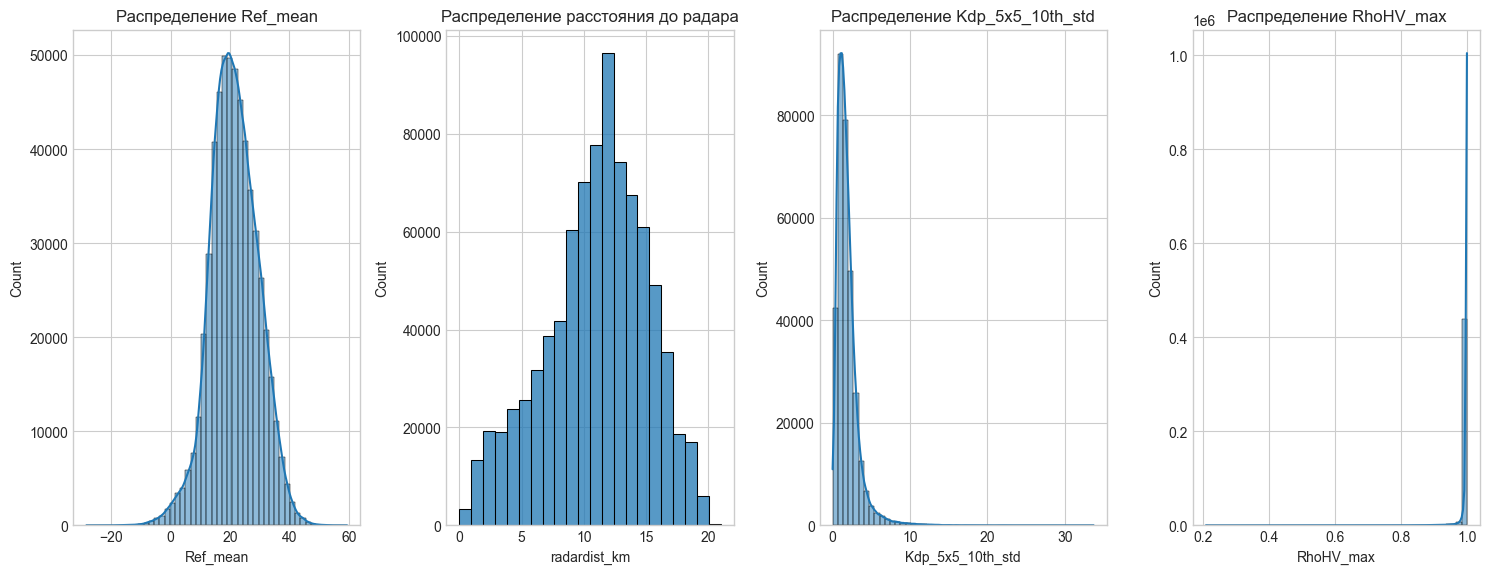

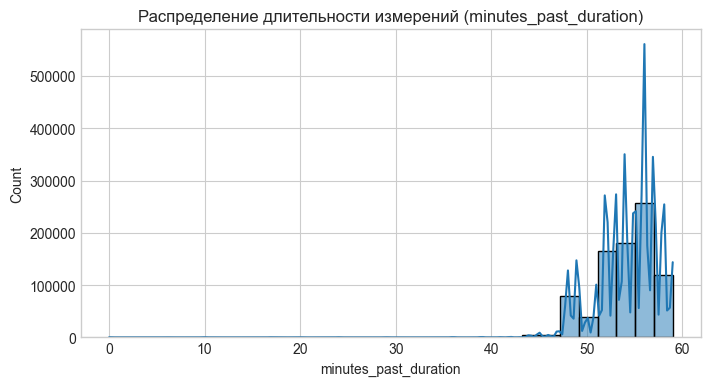

In [22]:
# Типы агрегированных признаков
numerical_cols = train_agg.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = train_agg.select_dtypes(exclude=[np.number]).columns.tolist()

logger.info(f"Числовые признаки: {len(numerical_cols)}")
logger.info(f"Категориальные признаки: {len(categorical_cols)}")

plt.figure(figsize=(15, 6))
plt.subplot(1, 4, 1)
sns.histplot(train_agg['Ref_mean'], bins=50, kde=True)
plt.title('Распределение Ref_mean')

plt.subplot(1, 4, 2)
sns.histplot(train_agg['radardist_km'], bins=train_agg['radardist_km'].nunique())
plt.title('Распределение расстояния до радара')

plt.subplot(1, 4, 3)
sns.histplot(train_agg['Kdp_5x5_10th_std'], bins=50, kde=True)
plt.title('Распределение Kdp_5x5_10th_std')

plt.subplot(1, 4, 4)
sns.histplot(train_agg['RhoHV_max'], bins=50, kde=True)
plt.title('Распределение RhoHV_max')

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(train_agg['minutes_past_duration'], bins=30, kde=True)
plt.title('Распределение длительности измерений (minutes_past_duration)')
plt.show()

Вывод:
Распределения признаков сильно различаются: одни близки к нормальному (например, Ref_mean), другие имеют дискретный характер (radardist_km), третьи сильно скошены (RhoHV_max, Kdp_5x5_std).

Для линейных моделей различный масштаб и форма распределений критичны, модели будут придавать больший вес признакам с большими значениями, и в таком случае нужна нормализация и стандартизация.\
Для бустингов и LAMA предобработка распределений не обязательна, они самостоятельно найдут оптимальные пороги разбиения, поэтому оставим так.

#### 2.7.2 Анализ зависимостей и важности признаков

Посмотрим на корреляцию между агрегированных признаков и таргетом, выделим топ наиболее скорелированных, и для топа построим попарную матрицу корреляций.

Топ 10 положительно коррелирующих признаков:

Ref_5x5_10th_max              0.359345
Ref_5x5_50th_max              0.348474
Ref_5x5_50th_mean             0.338199
Ref_max                       0.336811
Ref_mean                      0.333445
Ref_5x5_90th_mean             0.328608
Ref_5x5_10th_mean             0.327845
RefComposite_5x5_10th_max     0.327247
RefComposite_5x5_50th_max     0.324042
RefComposite_5x5_50th_mean    0.323941
dtype: float64

Топ 10 отрицательно коррелирующих признаков:

Kdp_nan_ratio                     -0.093766
Kdp_5x5_10th_nan_ratio            -0.098758
RefComposite_5x5_90th_nan_ratio   -0.140014
Ref_5x5_90th_nan_ratio            -0.142907
RefComposite_5x5_50th_nan_ratio   -0.152145
RefComposite_nan_ratio            -0.153165
Ref_5x5_50th_nan_ratio            -0.155851
RefComposite_5x5_10th_nan_ratio   -0.156684
Ref_nan_ratio                     -0.157145
Ref_5x5_10th_nan_ratio            -0.160763
dtype: float64


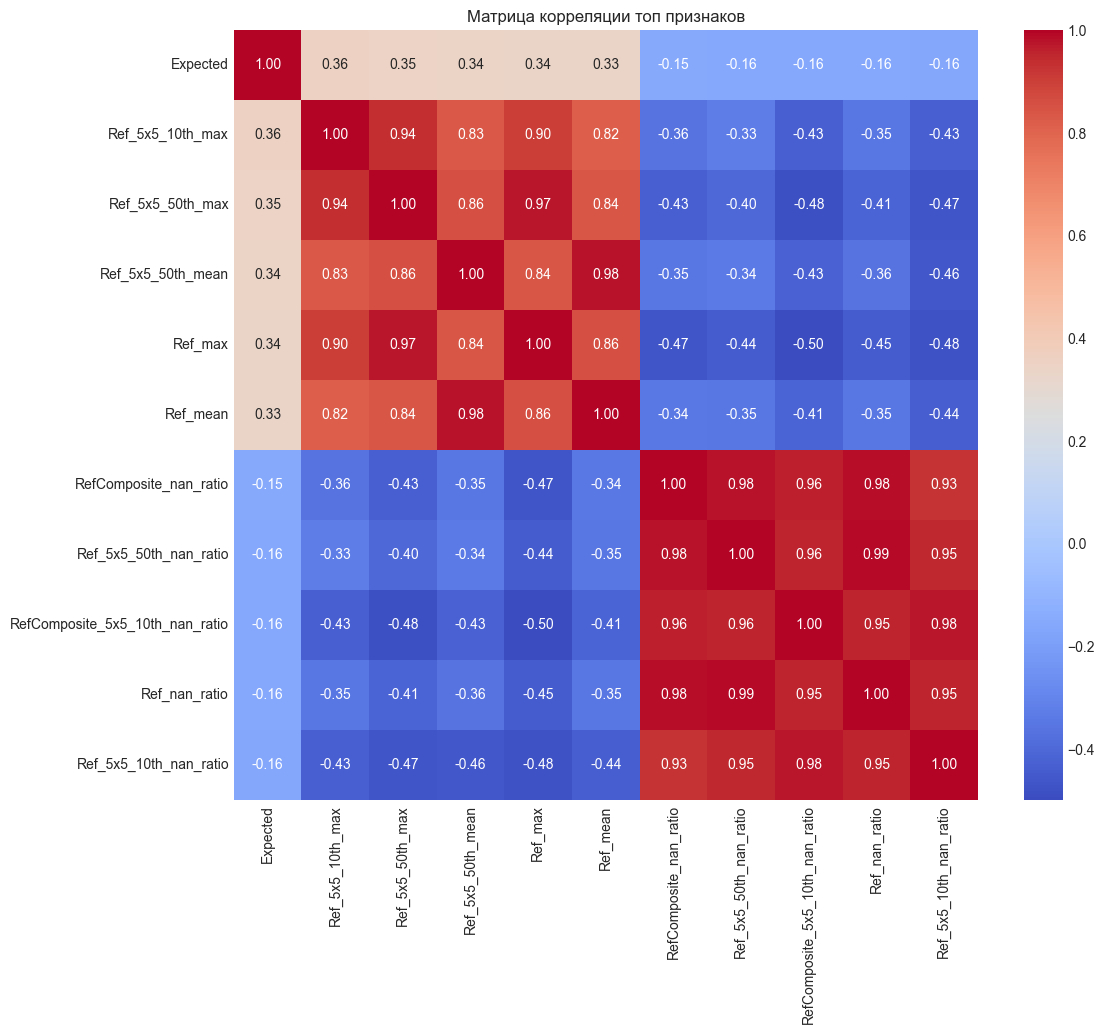

In [23]:
# Корреляция с целевой переменной
corr_with_target = train_agg.corrwith(train_agg['Expected']).sort_values(ascending=False)

print("Топ 10 положительно коррелирующих признаков:")
print(f"\n{corr_with_target.head(11).iloc[1:]}")

print("\nТоп 10 отрицательно коррелирующих признаков:")
print(f"\n{corr_with_target.tail(10)}")

# Тепловая карта топ коррелирующих признаков
top_corr_features = corr_with_target.head(6).index.tolist() + corr_with_target.tail(5).index.tolist()
if 'Expected' not in top_corr_features:
    top_corr_features.append('Expected')

plt.figure(figsize=(12, 10))
sns.heatmap(train_agg[top_corr_features].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Матрица корреляции топ признаков')
plt.show()

Выводы:

1.  Как видно из топа, ни один признак не имеет сильной линейной связи с таргетом. Это подтверждает, что зависимость является сложной и нелинейной.
2.  Между самими признаками (но обычно между различными агрегациями одного и того же показателя, например Ref_mean и Ref_max) наблюдается высокая корреляция.
3.  Как и в предыдущих пунктах, это все подталкивает нас к использованию бустингов, так как линейная модель здесь скорее всего сработает плохо (мультиколлинеарноость + нелинейность)

#### 2.7.3 Пропущенные значения

In [24]:
# Проверка пропусков в агрегированном датасете
agg_missing = train_agg.isnull().sum()
agg_missing_percent = (agg_missing / len(train_agg)) * 100
agg_missing_df = pd.DataFrame({'Missing Values': agg_missing, 'Percentage': agg_missing_percent})
agg_missing_df = agg_missing_df[agg_missing_df['Missing Values'] > 0].sort_values(by='Percentage', ascending=False)

print("Топ признаков с пропусками после агрегации:")
print(f"{agg_missing_df.head(5)}")

print("\nТоп признаков без пропусков после агрегации:")
print(f"{agg_missing_df.tail(5)}")

Топ признаков с пропусками после агрегации:
                   Missing Values  Percentage
Kdp_5x5_10th_std           528897   62.202613
Kdp_5x5_10th_min           492330   57.902035
Kdp_5x5_10th_mean          492330   57.902035
Kdp_5x5_10th_max           492330   57.902035
Zdr_5x5_10th_std           488978   57.507812

Топ признаков без пропусков после агрегации:
                            Missing Values  Percentage
Ref_5x5_90th_max                    239129   28.123526
Ref_5x5_90th_min                    239129   28.123526
RefComposite_5x5_90th_max           233267   27.434107
RefComposite_5x5_90th_min           233267   27.434107
RefComposite_5x5_90th_mean          233267   27.434107


Выводы:

В агрегированном датасете присутствует очень много пропусков, но это ожидаемо, если для какого-то Id радар не смог получить измерения определенного параметра за весь час, то агрегаты тоже будут NaN. Но так как мы склоняемся к бустингу, заполнять пропуски не обязательно, наоборот, заполнение может их запутать, и результат будет хуже.

## 3. Моделирование

### 3.1 Обоснование стратегии разбиения данных (Data Splitting Strategy)

Данные поделю на train и val 80/20. Как выяснили на этапе EDA, данные (Id) перемешаны и временная последовательность не сохранена.\
Утечка между train/val предотвращена split по Id, причем split сделала перед агрегацией, так как при агрегации отбрасываю выбросы. В val данные остались с выбросами в том числе.

In [25]:
# Формирование X и y из уже разделенных и агрегированных данных

X_train = train_agg.drop(columns=['Expected', 'Id'], errors='ignore')
y_train = train_agg['Expected']

X_val = val_agg.drop(columns=['Expected', 'Id'], errors='ignore')
y_val = val_agg['Expected']

logger.info(f"Размер обучающей выборки (X_train): {X_train.shape}")
logger.info(f"Размер валидационной выборки (X_val): {X_val.shape}")

2025-12-29 17:34:10,150 - INFO - Размер обучающей выборки (X_train): (850281, 123)
2025-12-29 17:34:10,151 - INFO - Размер валидационной выборки (X_val): (236189, 123)


### 3.2 LAMA Baseline (LightAutoML)

Построим бейзлайн с использованием библиотеки автоматического машинного обучения **LightAutoML (LAMA)**.
Мы протестируем две различные конфигурации:
1.  **Boosting Only (Baseline):** Пресет `TabularAutoML`, использующий только градиентный бустинг (CatBoost + LightGBM). Это быстрый и эффективный вариант для табличных данных.
2.  **Utilized Boosting Ensemble:** Пресет `TabularUtilizedAutoML`, который использует всё отведенное время (`TIMEOUT`) для построения взвешенного ансамбля бустингов. Это должно дать более стабильный и точный результат.

Метрика для оптимизации: **MAE**.

In [26]:
class LamaExperiment:
    """
    Класс для проведения экспериментов с LightAutoML.
    Инкапсулирует логику обучения, оценки и выбора лучшей конфигурации.
    Следует принципам SOLID и обеспечивает чистоту кода.
    """
    
    def __init__(self, task_type: str = 'reg', metric: str = 'mae', timeout: int = 600, random_state: int = 42):
        """
        Инициализация эксперимента.
        
        Args:
            task_type: Тип задачи ('reg', 'binary', 'multiclass').
            metric: Метрика для оптимизации.
            timeout: Ограничение времени на обучение (в секундах).
            random_state: Seed для воспроизводимости.
        """
        self.task = Task(task_type, loss=metric, metric=metric)
        self.timeout = timeout
        self.random_state = random_state
        self.models: Dict[str, Any] = {}
        self.results: Dict[str, float] = {}
        self.best_model_name: Optional[str] = None
        self.best_model: Optional[Any] = None

    def train_config(self, config_name: str, model_type: str, train_data: pd.DataFrame, roles: Dict[str, Any]) -> None:
        """
        Обучение специфической конфигурации LAMA.
        
        Args:
            config_name: Название конфигурации для отчета.
            model_type: Тип пресета ('tabular' или 'utilized').
            train_data: Обучающий датасет (X + y).
            roles: Роли признаков.
        """
        logger.info(f"Запуск обучения конфигурации: {config_name} ({model_type})...")
        
        params = {
            'task': self.task,
            'timeout': self.timeout,
            'cpu_limit': 4,
            'general_params': {'use_algos': [['lgb', 'cb']]},
            'reader_params': {'n_jobs': 4, 'cv': 5, 'random_state': self.random_state}
        }

        try:
            if model_type == 'tabular':
                automl = TabularAutoML(**params)
            elif model_type == 'utilized':
                automl = TabularUtilizedAutoML(**params)
            else:
                raise ValueError(f"Unknown model_type: {model_type}")

            automl.fit_predict(train_data, roles=roles)
            self.models[config_name] = automl
            logger.info(f"Обучение {config_name} завершено успешно.")
            
        except Exception as e:
            logger.error(f"Ошибка при обучении {config_name}: {e}")
            raise e

    def evaluate_all(self, X_val: pd.DataFrame, y_val: pd.Series) -> None:
        """
        Оценка всех обученных моделей на валидационной выборке.
        """
        logger.info("Начало оценки моделей...")
        for name, model in self.models.items():
            try:
                preds = model.predict(X_val).data[:, 0]
                mae = mean_absolute_error(y_val, preds)
                self.results[name] = mae
                logger.info(f"Модель: {name}, MAE: {mae:.5f}")
            except Exception as e:
                logger.error(f"Ошибка при оценке {name}: {e}")

    def get_best_model(self) -> Any:
        """
        Возвращает лучшую модель на основе метрики.
        """
        if not self.results:
            logger.warning("Нет результатов для сравнения.")
            return None

        self.best_model_name = min(self.results, key=self.results.get)
        self.best_model = self.models[self.best_model_name]
        
        logger.info("-" * 40)
        logger.info(f"Лучшая конфигурация LAMA: {self.best_model_name}")
        logger.info(f"MAE: {self.results[self.best_model_name]:.5f}")
        logger.info("-" * 40)
        
        return self.best_model

In [27]:
# Подготовка данных для LAMA
train_data = pd.concat([X_train, y_train], axis=1)
roles = {'target': 'Expected', 'drop': ['Id']}

# Инициализация эксперимента
lama_experiment = LamaExperiment()

# --- Config 1: Boosting Only (Baseline) ---
# Классический подход на деревьях
lama_experiment.train_config(
    config_name='Config 1 (Boosting Only)', 
    model_type='tabular', 
    train_data=train_data, 
    roles=roles
)

# --- Config 2: Utilized Boosting Ensemble ---
# TabularUtilizedAutoML создает ансамбль моделей, эффективно используя отведенное время
lama_experiment.train_config(
    config_name='Config 2 (Utilized Ensemble)', 
    model_type='utilized', 
    train_data=train_data, 
    roles=roles
)

# Оценка и выбор лучшего решения
lama_experiment.evaluate_all(X_val, y_val)
best_lama = lama_experiment.get_best_model()

# Сохраняем результаты
results_lama = lama_experiment.results
mae_1 = results_lama.get('Config 1 (Boosting Only)')
mae_2 = results_lama.get('Config 2 (Utilized Ensemble)')
automl_1 = lama_experiment.models.get('Config 1 (Boosting Only)')
automl_2 = lama_experiment.models.get('Config 2 (Utilized Ensemble)')

2025-12-29 17:34:10,467 - INFO - Запуск обучения конфигурации: Config 1 (Boosting Only) (tabular)...
2025-12-29 17:43:16,489 - INFO - Обучение Config 1 (Boosting Only) завершено успешно.
2025-12-29 17:43:16,489 - INFO - Запуск обучения конфигурации: Config 2 (Utilized Ensemble) (utilized)...
2025-12-29 17:52:31,774 - INFO - Обучение Config 2 (Utilized Ensemble) завершено успешно.
2025-12-29 17:52:31,774 - INFO - Начало оценки моделей...
2025-12-29 17:52:35,010 - INFO - Модель: Config 1 (Boosting Only), MAE: 131.37623
2025-12-29 17:52:40,312 - INFO - Модель: Config 2 (Utilized Ensemble), MAE: 131.37295
2025-12-29 17:52:40,312 - INFO - ----------------------------------------
2025-12-29 17:52:40,312 - INFO - Лучшая конфигурация LAMA: Config 2 (Utilized Ensemble)
2025-12-29 17:52:40,312 - INFO - MAE: 131.37295
2025-12-29 17:52:40,312 - INFO - ----------------------------------------


### 3.3 Custom Solution (XGBoost + Optuna)

Для кастомного решения возьму XGBoost (по моему опыту наиболее мощная библиотека градиентного бустинга, имхо).\
Фиксирую n_estimators. Это число - верхняя граница числа деревьев, фактическое число выбирается early stopping по MAE на eval_set\
Сделала внутренний split, использую для early stopping и выбора гиперпараметров (Optuna), внешний val использую только для финальной оценки качества без подглядывания

In [32]:
class CustomXGBoostPipeline:
    """
    Класс для управления жизненным циклом модели XGBoost:
    - Оптимизация гиперпараметров с Optuna
    - Создание финального пайплайна (sklearn Pipeline)
    - Обучение и предсказание
    """
    def __init__(self, random_state: int = 42, n_jobs: int = 4):
        self.random_state = random_state
        self.n_jobs = n_jobs
        self.best_params: Optional[Dict[str, Any]] = None
        self.pipeline: Optional[Pipeline] = None
        self.study: Optional[optuna.study.Study] = None
        self.best_iteration: Optional[int] = None

    def optimize(self, X_train: pd.DataFrame, y_train: pd.Series, n_trials: int = 20, timeout: int = 600) -> None:
        """
        Запуск оптимизации гиперпараметров с использованием Optuna.
        """
        logger.info("Запуск оптимизации XGBoost с Optuna...")
        
        def objective(trial: optuna.trial.Trial) -> float:
            # Внутренний сплит для early stopping, чтобы не использовать внешний X_val
            # Это предотвращает утечку данных из валидации в процесс выбора гиперпараметров
            X_train_in, X_val_in, y_train_in, y_val_in = train_test_split(
                X_train, y_train, test_size=0.2, random_state=42
            )

            params = {
                'objective': 'reg:absoluteerror', # MAE
                'eval_metric': 'mae',
                'verbosity': 0,
                'booster': 'gbtree',
                'n_estimators': 10000, # фиксирую большое число деревьев
                'early_stopping_rounds': 100,
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'max_depth': trial.suggest_int('max_depth', 3, 12),
                'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
                'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
                'random_state': self.random_state,
                'n_jobs': self.n_jobs
            }
            
            model = xgb.XGBRegressor(**params)
            
            # Используем внутренний валидационный сет для early stopping
            model.fit(
                X_train_in, y_train_in, 
                eval_set=[(X_val_in, y_val_in)], 
                verbose=False
            )
            
            # Оцениваем качество на внутреннем валидационном сете
            best_iter = model.best_iteration
            preds = model.predict(X_val_in, iteration_range=(0, best_iter + 1))
            mae = mean_absolute_error(y_val_in, preds)
            return mae

        self.study = optuna.create_study(direction='minimize')
        self.study.optimize(objective, n_trials=n_trials, timeout=timeout)
        self.best_params = self.study.best_params
        
        logger.info(f"Оптимизация завершена.")
        logger.info(f"Лучшие параметры: {self.best_params}")
        logger.info(f"Лучший MAE (Optuna): {self.study.best_value:.4f}")

    def fit_final_model(self, X_train: pd.DataFrame, y_train: pd.Series) -> None:
        """
        Обучение финальной модели с лучшими параметрами, обернутой в sklearn Pipeline.
        """
        if not self.best_params:
            logger.warning("Оптимизация не проводилась. Используются параметры по умолчанию.")
            self.best_params = {}
            
        logger.info("Обучение финального пайплайна...")

        # Внутренний сплит для early stopping при финальном обучении
        # Мы не используем внешний X_val для остановки, чтобы честно оценить качество модели в конце
        X_train_in, X_val_in, y_train_in, y_val_in = train_test_split(
            X_train, y_train, test_size=0.2, random_state=42
        )
        
        # Обновляем параметры для финального обучения
        final_params = self.best_params.copy()
        final_params.update({
            'n_estimators': 10000,
            'objective': 'reg:absoluteerror',
            'eval_metric': 'mae',
            'early_stopping_rounds': 100,
            'random_state': self.random_state,
            'n_jobs': self.n_jobs,
            'verbosity': 0
        })
        
        # Создаем sklearn Pipeline
        self.pipeline = Pipeline([
            ('xgb_model', xgb.XGBRegressor(**final_params))
        ])
        
        # Обучаем пайплайн на части train данных, используя другую часть для early stopping
        self.pipeline.fit(
            X_train_in, y_train_in,
            xgb_model__eval_set=[(X_val_in, y_val_in)],
            xgb_model__verbose=False
        )
        
        # Сохраняем best_iteration
        self.best_iteration = self.pipeline.named_steps['xgb_model'].best_iteration
        logger.info(f"Финальная модель обучена. Best iteration: {self.best_iteration}")
        
    def predict(self, X: pd.DataFrame) -> np.ndarray:
        """Предсказание с использованием пайплайна."""
        if self.pipeline is None:
             raise ValueError("Pipeline is not fitted yet.")
        
        # Если есть best_iteration, используем его явно
        if self.best_iteration is not None:
            # Обращаемся напрямую к модели внутри пайплайна, так как sklearn pipeline.predict не поддерживает iteration_range
            return self.pipeline.named_steps['xgb_model'].predict(X, iteration_range=(0, self.best_iteration + 1))
            
        return self.pipeline.predict(X)

# --- Запуск пайплайна ---
xgb_pipeline = CustomXGBoostPipeline()

# 1. Оптимизация
xgb_pipeline.optimize(X_train, y_train, n_trials=20, timeout=600)

# 2. Обучение финальной модели
xgb_pipeline.fit_final_model(X_train, y_train)

# 3. Оценка
final_pred_xgb = xgb_pipeline.predict(X_val)
final_mae_xgb = mean_absolute_error(y_val, final_pred_xgb)
logger.info(f"Финальный MAE Custom Solution (XGBoost): {final_mae_xgb:.4f}")

2025-12-29 19:17:06,972 - INFO - Запуск оптимизации XGBoost с Optuna...
2025-12-29 19:17:06,972 - INFO - A new study created in memory with name: no-name-a7b545dd-a096-4157-b7f5-f3ab23ff5666
2025-12-29 19:52:15,310 - INFO - Trial 0 finished with value: 1.762349811689971 and parameters: {'learning_rate': 0.08887011785478859, 'max_depth': 9, 'min_child_weight': 5, 'subsample': 0.9697029050097943, 'colsample_bytree': 0.5019250934286518, 'reg_alpha': 0.00014052776848461028, 'reg_lambda': 0.00016927663430059466}. Best is trial 0 with value: 1.762349811689971.
2025-12-29 19:52:15,310 - INFO - Оптимизация завершена.
2025-12-29 19:52:15,310 - INFO - Лучшие параметры: {'learning_rate': 0.08887011785478859, 'max_depth': 9, 'min_child_weight': 5, 'subsample': 0.9697029050097943, 'colsample_bytree': 0.5019250934286518, 'reg_alpha': 0.00014052776848461028, 'reg_lambda': 0.00016927663430059466}
2025-12-29 19:52:15,310 - INFO - Лучший MAE (Optuna): 1.7623
2025-12-29 19:52:15,310 - INFO - Обучение фин

In [33]:
# Итоговое сравнение всех моделей
results = {
    'LAMA Config 1 (Boosting)': mae_1,
    'LAMA Config 2 (Utilized)': mae_2,
    'Custom Solution (XGBoost)': final_mae_xgb
}

best_model_name = min(results, key=results.get)

print("=" * 40)
print("ИТОГОВАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ (MAE):")
print("=" * 40)
for name, score in results.items():
    print(f"{name:<30}: {score:.5f}")
print("-" * 40)
print(f"ПОБЕДИТЕЛЬ: {best_model_name}")
print("=" * 40)

ИТОГОВАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ (MAE):
LAMA Config 1 (Boosting)      : 131.37623
LAMA Config 2 (Utilized)      : 131.37295
Custom Solution (XGBoost)     : 131.35768
----------------------------------------
ПОБЕДИТЕЛЬ: Custom Solution (XGBoost)


В ноутбуке оставила только XGBoost, так как им удалось побить результаты LAMA, но экспериментов было несколько

## 4. Создание Submission файла

Используем лучшую конфигурацию LAMA (Config 2: Boosting Only) и XGBoost для предсказания на тестовом наборе данных, сравним два сабмишна на паблик и приват скорах.\
Предварительно обработаем тестовые данные тем же пайплайном, что и тренировочные.

In [34]:
# 1. Предобработка тестовых данных
logger.info("Начало обработки тестовых данных...")
# Используем уже созданный пайплайн
test_agg = preprocessing_pipeline.transform(test_df)
logger.info(f"Размер агрегированных тестовых данных: {test_agg.shape}")

os.makedirs('kaggle_submissions', exist_ok=True)

# --- 2. LAMA Config 1 (Boosting Only) ---
logger.info("Начало предсказания (LAMA Config 1)...")
test_pred_lama_1 = automl_1.predict(test_agg).data[:, 0]

submission_lama_1 = pd.DataFrame({
    'Id': test_agg.index,
    'Expected': test_pred_lama_1
})
submission_lama_1['Expected'] = submission_lama_1['Expected'].clip(lower=0)
submission_lama_1.to_csv('kaggle_submissions/submission_lama_config1.csv', index=False)
logger.info("Результаты Lama Config 1 записаны в файл kaggle_submissions/submission_lama_config1.csv")

# --- 3. LAMA Config 2 (Utilized Ensemble) ---
logger.info("Начало предсказания (LAMA Config 2)...")
test_pred_lama_2 = automl_2.predict(test_agg).data[:, 0]

submission_lama_2 = pd.DataFrame({
    'Id': test_agg.index,
    'Expected': test_pred_lama_2
})
submission_lama_2['Expected'] = submission_lama_2['Expected'].clip(lower=0)

submission_lama_2.to_csv('kaggle_submissions/submission_lama_config2.csv', index=False)
logger.info("Результаты Lama Config 2 записаны в файл kaggle_submissions/submission_lama_config2.csv")

# --- 4. Custom XGBoost ---
logger.info("Начало предсказания (Custom XGBoost)...")
test_pred_xgb = xgb_pipeline.predict(test_agg)

submission_xgb = pd.DataFrame({
    'Id': test_agg.index,
    'Expected': test_pred_xgb
})
submission_xgb['Expected'] = submission_xgb['Expected'].clip(lower=0)

submission_xgb.to_csv('kaggle_submissions/submission_xgboost.csv', index=False)
logger.info("Результаты Custom XGBoost записаны в файл kaggle_submissions/submission_xgboost.csv")

2025-12-29 20:29:13,168 - INFO - Начало обработки тестовых данных...
2025-12-29 20:29:14,026 - INFO - DataCleaner: Clipped 853767 values in 'RhoHV' > 1.0
2025-12-29 20:29:14,026 - INFO - DataAggregator: Starting aggregation...
2025-12-29 20:29:37,419 - INFO - DataAggregator: Aggregation complete. Output shape: (717625, 123)
2025-12-29 20:29:37,510 - INFO - Размер агрегированных тестовых данных: (717625, 123)
2025-12-29 20:29:37,511 - INFO - Начало предсказания (LAMA Config 1)...
2025-12-29 20:29:47,115 - INFO - Результаты Lama Config 1 записаны в файл kaggle_submissions/submission_lama_config1.csv
2025-12-29 20:29:47,115 - INFO - Начало предсказания (LAMA Config 2)...
2025-12-29 20:30:04,835 - INFO - Результаты Lama Config 2 записаны в файл kaggle_submissions/submission_lama_config2.csv
2025-12-29 20:30:04,836 - INFO - Начало предсказания (Custom XGBoost)...
2025-12-29 20:31:28,279 - INFO - Результаты Custom XGBoost записаны в файл kaggle_submissions/submission_xgboost.csv


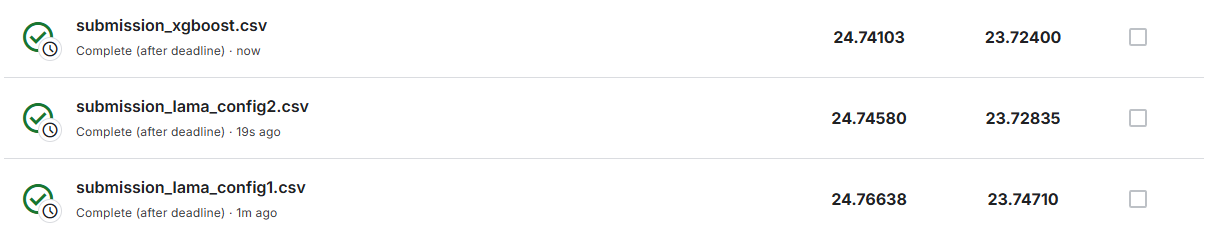
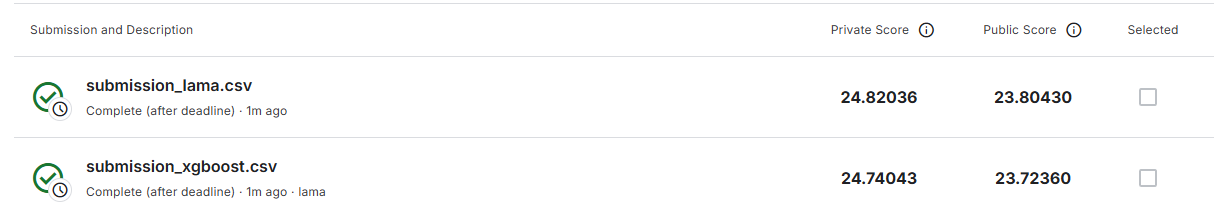

Скоры по паблик и приват лидерборду также лучше у XGBoost, в лидерборде (по приват скору) это примерно результат 22-23 места из 588

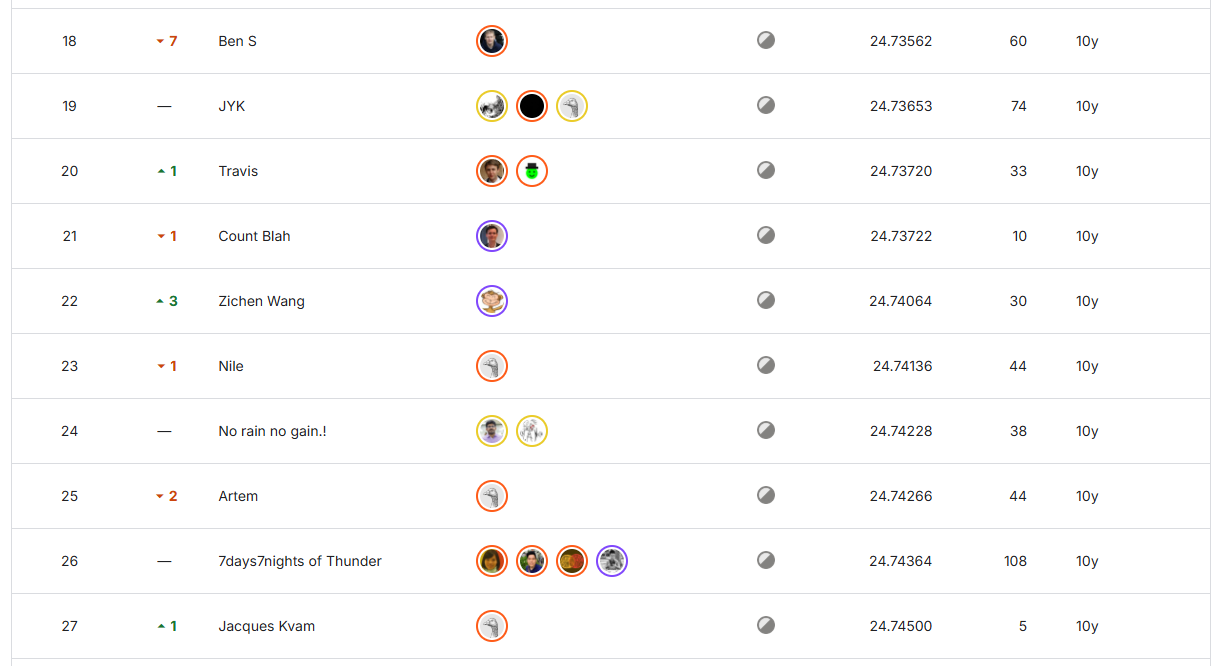